## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics

import matplotlib.pyplot as plt

np.random.seed(1234)

## 2. Metrics 📏

In [2]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 3. Load data 📊

In [3]:
df_train = pd.read_csv("../../data/train/protein/protein_maccs_train.csv")
df_test = pd.read_csv("../../data/train/protein/protein_maccs_test.csv")
df_valid = pd.read_csv("../../data/train/protein/protein_maccs_valid.csv")

df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train_all = df_train_all.loc[:, df_train_all.columns != 'protein_plasma_binding']
y_train_all = df_train_all['protein_plasma_binding']

X_train = df_train_all.loc[:, df_train_all.columns != 'protein_plasma_binding']
y_train = df_train_all['protein_plasma_binding']

X_test = df_test.loc[:, df_test.columns != 'protein_plasma_binding']
y_test = df_test['protein_plasma_binding']

X_valid = df_valid.loc[:, df_valid.columns != 'protein_plasma_binding']
y_valid = df_valid['protein_plasma_binding']

In [5]:
X_train.shape

(2130, 166)

In [6]:
X_test.shape

(533, 166)

In [7]:
X_valid.shape

(266, 166)

# 4. Model ⚙️

![FCNN](images/fcnn.png)

In [8]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(166, 300)
        self.linear2 = nn.Linear(300, 500)
        self.linear3 = nn.Linear(500, 600)
        self.linear4 = nn.Linear(600, 400)
        self.linear5 = nn.Linear(400, 50)
        self.linear6 = nn.Linear(50, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch = torch.nn.BatchNorm1d(500)
        self.batch2 = torch.nn.BatchNorm1d(600)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch(self.linear2(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch2(self.linear3(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.linear4(y_pred))
        y_pred = F.relu(self.linear5(y_pred))
        y_pred = self.dropout(y_pred)
        y_pred = self.linear6(y_pred)
        return y_pred

## 4.1. Grid search 🔎

In [9]:
lrs = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256]

In [10]:
best_value = 1000
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:
        
        model = FCNN()
        model.cuda()
        
        train_dataset = TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values.reshape(-1, 1)))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        valid_dataset = TensorDataset(torch.FloatTensor(X_valid.values), torch.FloatTensor(y_valid.values.reshape(-1, 1)))
        valid_loader = DataLoader(valid_dataset, batch_size=266, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        
        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0


            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0

            with torch.no_grad():
                for data, target in valid_loader:
                    data, target = data.cuda(), target.cuda()
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

Model: lr 0.001, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 2886.766734108996, Accuracy: -7.2000124387657465
Test Avg. loss: 2737.558837890625, Accuracy: -3.5950452018453527
################## EPOCH 2 ##################
Train Avg. loss: 1098.1826563593168, Accuracy: -2.114497673287251
Test Avg. loss: 1288.191162109375, Accuracy: -1.1622535486743253
################## EPOCH 3 ##################
Train Avg. loss: 1088.8715455923507, Accuracy: -2.0547231161326978
Test Avg. loss: 1397.0526123046875, Accuracy: -1.3449795393188535
################## EPOCH 4 ##################
Train Avg. loss: 970.0911500845383, Accuracy: -1.8753789394994518
Test Avg. loss: 996.7598876953125, Accuracy: -0.6730804932094754
################## EPOCH 5 ##################
Train Avg. loss: 970.6819212045242, Accuracy: -1.8469821566853384
Test Avg. loss: 953.9265747070312, Accuracy: -0.601183993208233
################## EPOCH 6 ##################
Train Avg. loss: 1002.0238146426072, 

Train Avg. loss: 700.5791744402985, Accuracy: -1.1608550885764943
Test Avg. loss: 213.91612243652344, Accuracy: 0.6409376784201511
################## EPOCH 48 ##################
Train Avg. loss: 701.9479194754985, Accuracy: -1.0824507019511826
Test Avg. loss: 277.2577819824219, Accuracy: 0.5346175037629044
################## EPOCH 49 ##################
Train Avg. loss: 685.0649505159748, Accuracy: -1.1008531061533875
Test Avg. loss: 203.270263671875, Accuracy: 0.6588069820015967
################## EPOCH 50 ##################
Train Avg. loss: 700.1638689183477, Accuracy: -1.1477171988854284
Test Avg. loss: 231.28466796875, Accuracy: 0.611784281898782
################## EPOCH 51 ##################
Train Avg. loss: 701.4763529763293, Accuracy: -1.1962781742140525
Test Avg. loss: 213.4442596435547, Accuracy: 0.6417297288388324
################## EPOCH 52 ##################
Train Avg. loss: 642.0810246254081, Accuracy: -0.9103108901922632
Test Avg. loss: 212.91098022460938, Accuracy: 0.6426

Train Avg. loss: 573.0636027321887, Accuracy: -0.8424868946508787
Test Avg. loss: 163.59344482421875, Accuracy: 0.7254052707921144
################## EPOCH 95 ##################
Train Avg. loss: 563.4553370689279, Accuracy: -0.6722422226804714
Test Avg. loss: 101.01725769042969, Accuracy: 0.8304405942368974
################## EPOCH 96 ##################
Train Avg. loss: 592.3166203285331, Accuracy: -0.8225840463082056
Test Avg. loss: 146.2435302734375, Accuracy: 0.7545274434320141
################## EPOCH 97 ##################
Train Avg. loss: 568.3668413304571, Accuracy: -0.8113110474286184
Test Avg. loss: 144.439453125, Accuracy: 0.7575556118334434
################## EPOCH 98 ##################
Train Avg. loss: 597.0986628745919, Accuracy: -0.7817738168609949
Test Avg. loss: 102.02837371826172, Accuracy: 0.8287434120150665
################## EPOCH 99 ##################
Train Avg. loss: 558.5557291970324, Accuracy: -0.7506484653262238
Test Avg. loss: 108.9266357421875, Accuracy: 0.817

Train Avg. loss: 552.4283870867829, Accuracy: -0.7883753656386492
Test Avg. loss: 109.34403228759766, Accuracy: 0.8164639431886214
################## EPOCH 142 ##################
Train Avg. loss: 555.6241650937209, Accuracy: -0.7832783059308295
Test Avg. loss: 83.19049835205078, Accuracy: 0.8603631616603571
################## EPOCH 143 ##################
Train Avg. loss: 541.7674678973298, Accuracy: -0.7244009465375781
Test Avg. loss: 116.48894500732422, Accuracy: 0.8044710792616772
################## EPOCH 144 ##################
Train Avg. loss: 532.1688870102612, Accuracy: -0.6588935714941625
Test Avg. loss: 79.86165618896484, Accuracy: 0.8659506810697916
################## EPOCH 145 ##################
Train Avg. loss: 520.0966368717934, Accuracy: -0.6663582696895866
Test Avg. loss: 79.92501831054688, Accuracy: 0.865844319424592
################## EPOCH 146 ##################
Train Avg. loss: 538.7938000123892, Accuracy: -0.6700988435669285
Test Avg. loss: 76.91825103759766, Accuracy

Train Avg. loss: 492.78123815735773, Accuracy: -0.5356476940029229
Test Avg. loss: 59.96024703979492, Accuracy: 0.8993555824511984
################## EPOCH 189 ##################
Train Avg. loss: 529.9891040858938, Accuracy: -0.5862413678727545
Test Avg. loss: 70.1063232421875, Accuracy: 0.8823251988868259
################## EPOCH 190 ##################
Train Avg. loss: 472.79358798354417, Accuracy: -0.5131957611591874
Test Avg. loss: 72.42652893066406, Accuracy: 0.8784306856741981
################## EPOCH 191 ##################
Train Avg. loss: 486.8900702177589, Accuracy: -0.4559792209307681
Test Avg. loss: 68.75305938720703, Accuracy: 0.8845966809232783
################## EPOCH 192 ##################
Train Avg. loss: 472.8949639619286, Accuracy: -0.45665771600948063
Test Avg. loss: 65.83704376220703, Accuracy: 0.8894912595821365
################## EPOCH 193 ##################
Train Avg. loss: 452.2970460350834, Accuracy: -0.43055898480902277
Test Avg. loss: 74.56807708740234, Accura

Train Avg. loss: 465.07493090273726, Accuracy: -0.4470311297955989
Test Avg. loss: 55.25174331665039, Accuracy: 0.9072588917543837
################## EPOCH 235 ##################
Train Avg. loss: 454.91099662211406, Accuracy: -0.4291989028632942
Test Avg. loss: 60.40629577636719, Accuracy: 0.8986068774829482
################## EPOCH 236 ##################
Train Avg. loss: 457.89097572440534, Accuracy: -0.4050394689359049
Test Avg. loss: 66.40467834472656, Accuracy: 0.888538468575223
################## EPOCH 237 ##################
Train Avg. loss: 469.5122302610483, Accuracy: -0.48794710686000403
Test Avg. loss: 67.10993194580078, Accuracy: 0.8873546832185086
################## EPOCH 238 ##################
Train Avg. loss: 447.95434957475806, Accuracy: -0.39244262469486735
Test Avg. loss: 70.72907257080078, Accuracy: 0.8812798954782108
################## EPOCH 239 ##################
Train Avg. loss: 462.77015207774605, Accuracy: -0.5140544626826475
Test Avg. loss: 80.89737701416016, Acc

Train Avg. loss: 411.545826470674, Accuracy: -0.2761740257433699
Test Avg. loss: 65.51612854003906, Accuracy: 0.8900299388682299
################## EPOCH 281 ##################
Train Avg. loss: 439.59553459509095, Accuracy: -0.36960920073939
Test Avg. loss: 88.01583099365234, Accuracy: 0.8522637365810479
################## EPOCH 282 ##################
Train Avg. loss: 414.2751175609987, Accuracy: -0.30476407313330195
Test Avg. loss: 57.61566925048828, Accuracy: 0.9032909990378845
################## EPOCH 283 ##################
Train Avg. loss: 427.07204334771455, Accuracy: -0.3762210015541274
Test Avg. loss: 55.85235595703125, Accuracy: 0.9062507538789509
################## EPOCH 284 ##################
Train Avg. loss: 424.98043231110074, Accuracy: -0.4227332792882296
Test Avg. loss: 63.245052337646484, Accuracy: 0.8938419604013361
################## EPOCH 285 ##################
Train Avg. loss: 438.3105245561742, Accuracy: -0.3668263835663988
Test Avg. loss: 64.51732635498047, Accurac

Train Avg. loss: 633.3642856373507, Accuracy: -0.43769145232706325
Test Avg. loss: 470.8320617675781, Accuracy: 0.20969934777267352
################## EPOCH 27 ##################
Train Avg. loss: 648.2049039952896, Accuracy: -0.4688192679960507
Test Avg. loss: 397.88348388671875, Accuracy: 0.3321449545197386
################## EPOCH 28 ##################
Train Avg. loss: 636.8326442942899, Accuracy: -0.44663386777280367
Test Avg. loss: 334.1653137207031, Accuracy: 0.4390971022690705
################## EPOCH 29 ##################
Train Avg. loss: 616.7500502642463, Accuracy: -0.41177070927251086
Test Avg. loss: 384.2492370605469, Accuracy: 0.35503026619092715
################## EPOCH 30 ##################
Train Avg. loss: 622.2544376148898, Accuracy: -0.4207746634427859
Test Avg. loss: 404.3017883300781, Accuracy: 0.3213716818322786
################## EPOCH 31 ##################
Train Avg. loss: 645.3934362074908, Accuracy: -0.45625446331677183
Test Avg. loss: 364.7480773925781, Accurac

Train Avg. loss: 489.65772202435664, Accuracy: -0.1508566033667227
Test Avg. loss: 111.66520690917969, Accuracy: 0.8125678199881535
################## EPOCH 74 ##################
Train Avg. loss: 492.283125035903, Accuracy: -0.16013095198758756
Test Avg. loss: 189.3639373779297, Accuracy: 0.6821490165346176
################## EPOCH 75 ##################
Train Avg. loss: 483.77256236356845, Accuracy: -0.11493108155467384
Test Avg. loss: 140.573486328125, Accuracy: 0.7640446971930539
################## EPOCH 76 ##################
Train Avg. loss: 495.1152747659122, Accuracy: -0.13456684560848323
Test Avg. loss: 148.6945343017578, Accuracy: 0.7504133839111606
################## EPOCH 77 ##################
Train Avg. loss: 507.2264440199908, Accuracy: -0.182813393277005
Test Avg. loss: 139.36398315429688, Accuracy: 0.7660748849904269
################## EPOCH 78 ##################
Train Avg. loss: 486.20903463924634, Accuracy: -0.1182487217929871
Test Avg. loss: 134.904052734375, Accuracy: 

Train Avg. loss: 457.19149421243105, Accuracy: -0.07790905521408827
Test Avg. loss: 72.1126937866211, Accuracy: 0.8789574582332299
################## EPOCH 120 ##################
Train Avg. loss: 453.8625757553998, Accuracy: -0.1035517892139558
Test Avg. loss: 119.52940368652344, Accuracy: 0.799367620545326
################## EPOCH 121 ##################
Train Avg. loss: 471.50824782427617, Accuracy: -0.14204337439443582
Test Avg. loss: 90.84172821044922, Accuracy: 0.847520416405948
################## EPOCH 122 ##################
Train Avg. loss: 458.4651695700253, Accuracy: -0.08935523224665974
Test Avg. loss: 113.21035766601562, Accuracy: 0.8099742458005351
################## EPOCH 123 ##################
Train Avg. loss: 432.232042649213, Accuracy: 0.002094591474572357
Test Avg. loss: 97.12042999267578, Accuracy: 0.8369815104892009
################## EPOCH 124 ##################
Train Avg. loss: 470.1552501005285, Accuracy: -0.11644561893673899
Test Avg. loss: 129.72000122070312, Acc

Train Avg. loss: 440.00049007640166, Accuracy: -0.039845094189958526
Test Avg. loss: 84.75421142578125, Accuracy: 0.8577384422836883
################## EPOCH 166 ##################
Train Avg. loss: 416.3982795266544, Accuracy: 0.020601654678808264
Test Avg. loss: 89.33226776123047, Accuracy: 0.8500540734056119
################## EPOCH 167 ##################
Train Avg. loss: 398.4346335915958, Accuracy: 0.04079497729020652
Test Avg. loss: 76.09291076660156, Accuracy: 0.8722766008919053
################## EPOCH 168 ##################
Train Avg. loss: 408.8271125344669, Accuracy: 0.05989451302845644
Test Avg. loss: 96.62957000732422, Accuracy: 0.8378054153152095
################## EPOCH 169 ##################
Train Avg. loss: 404.8105931001551, Accuracy: 0.028255908994994843
Test Avg. loss: 61.80628204345703, Accuracy: 0.8962569659761441
################## EPOCH 170 ##################
Train Avg. loss: 411.35589330336626, Accuracy: 0.03605754839174716
Test Avg. loss: 77.48866271972656, Acc

Train Avg. loss: 376.0844941980699, Accuracy: 0.131102948966125
Test Avg. loss: 81.19049835205078, Accuracy: 0.8637201958643426
################## EPOCH 212 ##################
Train Avg. loss: 370.19069447236905, Accuracy: 0.15711376815949848
Test Avg. loss: 57.3096809387207, Accuracy: 0.9038046061234755
################## EPOCH 213 ##################
Train Avg. loss: 379.46497300091914, Accuracy: 0.09388070480644058
Test Avg. loss: 71.87252044677734, Accuracy: 0.8793605940562179
################## EPOCH 214 ##################
Train Avg. loss: 375.5929035859949, Accuracy: 0.09113790268411924
Test Avg. loss: 85.71734619140625, Accuracy: 0.8561217947664697
################## EPOCH 215 ##################
Train Avg. loss: 376.570811103372, Accuracy: 0.12246423101120589
Test Avg. loss: 60.528907775878906, Accuracy: 0.8984010644907151
################## EPOCH 216 ##################
Train Avg. loss: 370.7474001716165, Accuracy: 0.11407709116448263
Test Avg. loss: 60.88616943359375, Accuracy: 

Train Avg. loss: 378.43775311638325, Accuracy: 0.13507280001687538
Test Avg. loss: 49.930625915527344, Accuracy: 0.9161904896297108
################## EPOCH 259 ##################
Train Avg. loss: 344.33788838106045, Accuracy: 0.20684784366566064
Test Avg. loss: 48.13136291503906, Accuracy: 0.9192105887954038
################## EPOCH 260 ##################
Train Avg. loss: 367.0383004581227, Accuracy: 0.12887543345335534
Test Avg. loss: 72.7056655883789, Accuracy: 0.8779621447929167
################## EPOCH 261 ##################
Train Avg. loss: 360.98225537468403, Accuracy: 0.14592918252696452
Test Avg. loss: 57.62792205810547, Accuracy: 0.9032704295502206
################## EPOCH 262 ##################
Train Avg. loss: 366.0016928280101, Accuracy: 0.1509500084716092
Test Avg. loss: 64.59771728515625, Accuracy: 0.8915714896104469
################## EPOCH 263 ##################
Train Avg. loss: 362.19148344152114, Accuracy: 0.16143994632836392
Test Avg. loss: 50.4366569519043, Accurac

Train Avg. loss: 900.3912568933823, Accuracy: -0.7943975778674086
Test Avg. loss: 2360.0732421875, Accuracy: -2.961428077152703
################## EPOCH 5 ##################
Train Avg. loss: 902.528564453125, Accuracy: -0.7954922685899903
Test Avg. loss: 1554.0372314453125, Accuracy: -1.6084813435565146
################## EPOCH 6 ##################
Train Avg. loss: 803.9526187672335, Accuracy: -0.6335772973329468
Test Avg. loss: 1580.1153564453125, Accuracy: -1.652253957101082
################## EPOCH 7 ##################
Train Avg. loss: 852.1264325310202, Accuracy: -0.699756875925073
Test Avg. loss: 1504.07470703125, Accuracy: -1.5246183863451845
################## EPOCH 8 ##################
Train Avg. loss: 831.2674345128677, Accuracy: -0.6556713529397216
Test Avg. loss: 1244.4722900390625, Accuracy: -1.0888705548161233
################## EPOCH 9 ##################
Train Avg. loss: 808.135160558364, Accuracy: -0.6307155998415618
Test Avg. loss: 1523.4410400390625, Accuracy: -1.55712

Train Avg. loss: 630.7941732967602, Accuracy: -0.26468506724348206
Test Avg. loss: 385.2464904785156, Accuracy: 0.3533563957858238
################## EPOCH 53 ##################
Train Avg. loss: 570.523432114545, Accuracy: -0.14577199530844695
Test Avg. loss: 334.4342041015625, Accuracy: 0.438645821724266
################## EPOCH 54 ##################
Train Avg. loss: 554.4366903866039, Accuracy: -0.12301702414209748
Test Avg. loss: 355.71441650390625, Accuracy: 0.40292660924022283
################## EPOCH 55 ##################
Train Avg. loss: 576.5008760340073, Accuracy: -0.16508753510851293
Test Avg. loss: 321.4456787109375, Accuracy: 0.4604472867009568
################## EPOCH 56 ##################
Train Avg. loss: 585.0553301642923, Accuracy: -0.20119471540465494
Test Avg. loss: 476.4435119628906, Accuracy: 0.20028049481624177
################## EPOCH 57 ##################
Train Avg. loss: 586.7416902429917, Accuracy: -0.19376866412112553
Test Avg. loss: 302.3255920410156, Accurac

Train Avg. loss: 568.8547076056985, Accuracy: -0.15732408520997676
Test Avg. loss: 282.15618896484375, Accuracy: 0.5263954215824513
################## EPOCH 101 ##################
Train Avg. loss: 499.68280029296875, Accuracy: -0.029344527875293278
Test Avg. loss: 235.87168884277344, Accuracy: 0.6040848366828553
################## EPOCH 102 ##################
Train Avg. loss: 502.8838159897748, Accuracy: -0.03979766692755224
Test Avg. loss: 338.02874755859375, Accuracy: 0.43261229410845514
################## EPOCH 103 ##################
Train Avg. loss: 501.8929281795726, Accuracy: -0.02084178822313299
Test Avg. loss: 328.7406921386719, Accuracy: 0.4482024892180111
################## EPOCH 104 ##################
Train Avg. loss: 514.8360757266773, Accuracy: -0.050692430996726406
Test Avg. loss: 300.3180236816406, Accuracy: 0.4959104492392318
################## EPOCH 105 ##################
Train Avg. loss: 502.1647733800551, Accuracy: -0.010942127170824904
Test Avg. loss: 238.0528411865

Train Avg. loss: 496.2730766745175, Accuracy: -0.01162669451990674
Test Avg. loss: 201.25546264648438, Accuracy: 0.6621888213005973
################## EPOCH 147 ##################
Train Avg. loss: 468.122849408318, Accuracy: 0.03842895302453594
Test Avg. loss: 146.83285522460938, Accuracy: 0.7535382456031106
################## EPOCH 148 ##################
Train Avg. loss: 495.59717694450825, Accuracy: -0.014574151842434243
Test Avg. loss: 159.33641052246094, Accuracy: 0.7325507948740435
################## EPOCH 149 ##################
Train Avg. loss: 527.5529013241039, Accuracy: -0.07161875738950023
Test Avg. loss: 159.95947265625, Accuracy: 0.7315049602808933
################## EPOCH 150 ##################
Train Avg. loss: 488.23035386029414, Accuracy: 0.010184149161552492
Test Avg. loss: 137.11474609375, Accuracy: 0.7698502689956963
################## EPOCH 151 ##################
Train Avg. loss: 476.85838946174175, Accuracy: 0.035045013449443295
Test Avg. loss: 156.5816192626953, Ac

Train Avg. loss: 470.667870016659, Accuracy: 0.03414452202404254
Test Avg. loss: 100.54410552978516, Accuracy: 0.8312347988025113
################## EPOCH 193 ##################
Train Avg. loss: 471.4451222139246, Accuracy: 0.03634046399377693
Test Avg. loss: 100.72980499267578, Accuracy: 0.8309230973065419
################## EPOCH 194 ##################
Train Avg. loss: 452.7259036793428, Accuracy: 0.09325910006289688
Test Avg. loss: 114.99440002441406, Accuracy: 0.806979702148918
################## EPOCH 195 ##################
Train Avg. loss: 501.42744535558364, Accuracy: -0.021013980589073816
Test Avg. loss: 112.40762329101562, Accuracy: 0.8113216459233908
################## EPOCH 196 ##################
Train Avg. loss: 458.7247314453125, Accuracy: 0.05601222789523369
Test Avg. loss: 139.5106964111328, Accuracy: 0.7658286436040498
################## EPOCH 197 ##################
Train Avg. loss: 457.112746294807, Accuracy: 0.07370083257871043
Test Avg. loss: 137.04591369628906, Accu

Train Avg. loss: 443.64249375287227, Accuracy: 0.1073083759434884
Test Avg. loss: 86.67053985595703, Accuracy: 0.8545218295410635
################## EPOCH 239 ##################
Train Avg. loss: 454.2885203642004, Accuracy: 0.08951469869291612
Test Avg. loss: 112.66556549072266, Accuracy: 0.8108886865936502
################## EPOCH 240 ##################
Train Avg. loss: 444.31312830307905, Accuracy: 0.08945143259886804
Test Avg. loss: 113.38787841796875, Accuracy: 0.809676273447308
################## EPOCH 241 ##################
Train Avg. loss: 436.2817185345818, Accuracy: 0.11466385201708969
Test Avg. loss: 124.8596420288086, Accuracy: 0.7904207100433258
################## EPOCH 242 ##################
Train Avg. loss: 460.1881570255055, Accuracy: 0.05654911968898114
Test Avg. loss: 79.70047760009766, Accuracy: 0.8662212281861227
################## EPOCH 243 ##################
Train Avg. loss: 451.4242481904871, Accuracy: 0.08232952243092964
Test Avg. loss: 78.55599975585938, Accurac

Train Avg. loss: 422.61540132410386, Accuracy: 0.14405322600916312
Test Avg. loss: 78.59332275390625, Accuracy: 0.8680795869570734
################## EPOCH 285 ##################
Train Avg. loss: 417.5845677992877, Accuracy: 0.14277436382435232
Test Avg. loss: 92.86908721923828, Accuracy: 0.8441174714229726
################## EPOCH 286 ##################
Train Avg. loss: 432.83145500631895, Accuracy: 0.11817380980930965
Test Avg. loss: 85.40272521972656, Accuracy: 0.8566498851516804
################## EPOCH 287 ##################
Train Avg. loss: 443.9300375545726, Accuracy: 0.0920576640220198
Test Avg. loss: 92.73213195800781, Accuracy: 0.8443473549270508
################## EPOCH 288 ##################
Train Avg. loss: 419.8491408404182, Accuracy: 0.1427607718486031
Test Avg. loss: 64.70604705810547, Accuracy: 0.891389658317681
################## EPOCH 289 ##################
Train Avg. loss: 423.1944885253906, Accuracy: 0.13049721962210814
Test Avg. loss: 74.68571472167969, Accuracy: 

Train Avg. loss: 695.8842027452257, Accuracy: -0.3676899975296563
Test Avg. loss: 1155.7847900390625, Accuracy: -0.9400070072417093
################## EPOCH 32 ##################
Train Avg. loss: 684.2755262586805, Accuracy: -0.32700261771519773
Test Avg. loss: 993.3409423828125, Accuracy: -0.6673419042569506
################## EPOCH 33 ##################
Train Avg. loss: 718.8278469509548, Accuracy: -0.4068772838073839
Test Avg. loss: 864.9927368164062, Accuracy: -0.45190693274691784
################## EPOCH 34 ##################
Train Avg. loss: 708.0319417317709, Accuracy: -0.3859403808131013
Test Avg. loss: 942.5909423828125, Accuracy: -0.582157013654335
################## EPOCH 35 ##################
Train Avg. loss: 707.5696207682291, Accuracy: -0.3792109620927223
Test Avg. loss: 856.0233764648438, Accuracy: -0.43685163099067803
################## EPOCH 36 ##################
Train Avg. loss: 720.670912000868, Accuracy: -0.4098408414463537
Test Avg. loss: 860.6170043945312, Accurac

Train Avg. loss: 573.3386840820312, Accuracy: -0.12334016122852064
Test Avg. loss: 357.5118103027344, Accuracy: 0.39990956176440495
################## EPOCH 78 ##################
Train Avg. loss: 549.0177883572048, Accuracy: -0.07942473573077724
Test Avg. loss: 430.30950927734375, Accuracy: 0.2777172762579272
################## EPOCH 79 ##################
Train Avg. loss: 573.968237982856, Accuracy: -0.11853274669030665
Test Avg. loss: 296.5678405761719, Accuracy: 0.5022051784927394
################## EPOCH 80 ##################
Train Avg. loss: 586.3132595486111, Accuracy: -0.1531982268794217
Test Avg. loss: 397.2257385253906, Accuracy: 0.3332489246521716
################## EPOCH 81 ##################
Train Avg. loss: 565.1043124728733, Accuracy: -0.10458266352626176
Test Avg. loss: 351.57708740234375, Accuracy: 0.40987115574386535
################## EPOCH 82 ##################
Train Avg. loss: 590.8629421657986, Accuracy: -0.1611020041021921
Test Avg. loss: 270.7702941894531, Accurac

Train Avg. loss: 552.8340182834202, Accuracy: -0.07785000053681716
Test Avg. loss: 222.56646728515625, Accuracy: 0.6264179225393688
################## EPOCH 125 ##################
Train Avg. loss: 550.3232252332899, Accuracy: -0.06428831267079922
Test Avg. loss: 229.52847290039062, Accuracy: 0.6147320472289783
################## EPOCH 126 ##################
Train Avg. loss: 555.3079596625435, Accuracy: -0.08801297226758635
Test Avg. loss: 297.7757263183594, Accuracy: 0.5001777286031799
################## EPOCH 127 ##################
Train Avg. loss: 546.4756808810764, Accuracy: -0.06980304011158198
Test Avg. loss: 257.51751708984375, Accuracy: 0.5677519424232917
################## EPOCH 128 ##################
Train Avg. loss: 502.5359870062934, Accuracy: 0.02010329011053871
Test Avg. loss: 204.9007110595703, Accuracy: 0.6560702534224241
################## EPOCH 129 ##################
Train Avg. loss: 535.7962578667534, Accuracy: -0.04269953477771086
Test Avg. loss: 165.02023315429688, 

Train Avg. loss: 520.2901272243923, Accuracy: -0.012401387521476522
Test Avg. loss: 245.3292999267578, Accuracy: 0.5882100643017021
################## EPOCH 171 ##################
Train Avg. loss: 526.730234781901, Accuracy: -0.03763504875573455
Test Avg. loss: 153.2624053955078, Accuracy: 0.7427461233449775
################## EPOCH 172 ##################
Train Avg. loss: 514.3183152940538, Accuracy: -0.0127959114754729
Test Avg. loss: 191.6895294189453, Accuracy: 0.6782454481688099
################## EPOCH 173 ##################
Train Avg. loss: 506.6512858072917, Accuracy: 0.011973778981706781
Test Avg. loss: 158.9397430419922, Accuracy: 0.7332165999193532
################## EPOCH 174 ##################
Train Avg. loss: 518.2092759874132, Accuracy: -0.008067452031461161
Test Avg. loss: 201.04107666015625, Accuracy: 0.6625486955799583
################## EPOCH 175 ##################
Train Avg. loss: 523.42431640625, Accuracy: -0.042264978677338375
Test Avg. loss: 151.89382934570312, Ac

Train Avg. loss: 509.58014594184027, Accuracy: 0.0021011672236926162
Test Avg. loss: 183.0086669921875, Accuracy: 0.6928164464538812
################## EPOCH 218 ##################
Train Avg. loss: 500.7969021267361, Accuracy: 0.01935810228214728
Test Avg. loss: 147.2235107421875, Accuracy: 0.7528825122922079
################## EPOCH 219 ##################
Train Avg. loss: 500.00450642903644, Accuracy: 0.021163992946001218
Test Avg. loss: 156.61578369140625, Accuracy: 0.7371174244219502
################## EPOCH 220 ##################
Train Avg. loss: 471.99957275390625, Accuracy: 0.0780241603887582
Test Avg. loss: 173.30078125, Accuracy: 0.709111337860731
################## EPOCH 221 ##################
Train Avg. loss: 516.2604573567709, Accuracy: 0.0014305128251243466
Test Avg. loss: 214.63552856445312, Accuracy: 0.6397301551655981
################## EPOCH 222 ##################
Train Avg. loss: 494.6862080891927, Accuracy: 0.031218896713352588
Test Avg. loss: 157.78192138671875, Accu

Train Avg. loss: 476.55919392903644, Accuracy: 0.06676841865450961
Test Avg. loss: 113.33699798583984, Accuracy: 0.8097616840638593
################## EPOCH 264 ##################
Train Avg. loss: 509.7206793891059, Accuracy: 0.0008644045834252193
Test Avg. loss: 198.68057250976562, Accuracy: 0.666510859968304
################## EPOCH 265 ##################
Train Avg. loss: 494.97130330403644, Accuracy: 0.03611729702122257
Test Avg. loss: 162.8684539794922, Accuracy: 0.7266221949109587
################## EPOCH 266 ##################
Train Avg. loss: 491.591790093316, Accuracy: 0.04219888084612665
Test Avg. loss: 152.4357452392578, Accuracy: 0.7441336808530917
################## EPOCH 267 ##################
Train Avg. loss: 478.5410325792101, Accuracy: 0.060782244378366296
Test Avg. loss: 135.31602478027344, Accuracy: 0.7728694391527855
################## EPOCH 268 ##################
Train Avg. loss: 493.7392069498698, Accuracy: 0.034809841606497395
Test Avg. loss: 223.77552795410156, A

Train Avg. loss: 835.5177758060285, Accuracy: -1.2982282855649103
Test Avg. loss: 466.2458801269531, Accuracy: 0.21739742705415777
################## EPOCH 10 ##################
Train Avg. loss: 755.2763011419951, Accuracy: -1.1489263009405712
Test Avg. loss: 635.1571655273438, Accuracy: -0.06612347665064355
################## EPOCH 11 ##################
Train Avg. loss: 751.2625568446829, Accuracy: -1.23152804880384
Test Avg. loss: 388.7553405761719, Accuracy: 0.3474667627908913
################## EPOCH 12 ##################
Train Avg. loss: 772.7697494279092, Accuracy: -1.1300431153547135
Test Avg. loss: 568.11181640625, Accuracy: 0.046413455620793576
################## EPOCH 13 ##################
Train Avg. loss: 765.1034026644123, Accuracy: -1.2011177614697257
Test Avg. loss: 485.5022888183594, Accuracy: 0.18507505740417274
################## EPOCH 14 ##################
Train Avg. loss: 745.8212999941697, Accuracy: -1.2034059761160087
Test Avg. loss: 310.4158935546875, Accuracy: 0.

Train Avg. loss: 510.6773230709247, Accuracy: -0.5159209006003267
Test Avg. loss: 154.9730682373047, Accuracy: 0.7398747203588041
################## EPOCH 57 ##################
Train Avg. loss: 472.4857514794193, Accuracy: -0.4139033380208342
Test Avg. loss: 137.1328125, Accuracy: 0.7698199581328663
################## EPOCH 58 ##################
Train Avg. loss: 464.9276888263759, Accuracy: -0.42347610433886346
Test Avg. loss: 161.91641235351562, Accuracy: 0.7282201839391741
################## EPOCH 59 ##################
Train Avg. loss: 472.26120222860305, Accuracy: -0.43980767455269465
Test Avg. loss: 196.81394958496094, Accuracy: 0.6696440354054385
################## EPOCH 60 ##################
Train Avg. loss: 468.54369730024194, Accuracy: -0.3741554052043829
Test Avg. loss: 187.9905242919922, Accuracy: 0.6844543201433477
################## EPOCH 61 ##################
Train Avg. loss: 467.91342664120805, Accuracy: -0.43083683003594453
Test Avg. loss: 157.32757568359375, Accuracy: 0

Train Avg. loss: 357.8326773572324, Accuracy: -0.0976953474779353
Test Avg. loss: 114.07024383544922, Accuracy: 0.8085309335670425
################## EPOCH 103 ##################
Train Avg. loss: 354.3929252055154, Accuracy: -0.1483069579802707
Test Avg. loss: 119.30620574951172, Accuracy: 0.7997422494108025
################## EPOCH 104 ##################
Train Avg. loss: 387.5662108464027, Accuracy: -0.1314013908917027
Test Avg. loss: 135.26791381835938, Accuracy: 0.7729502067800238
################## EPOCH 105 ##################
Train Avg. loss: 373.87068586207147, Accuracy: -0.10655979647603427
Test Avg. loss: 186.21841430664062, Accuracy: 0.6874288407412474
################## EPOCH 106 ##################
Train Avg. loss: 362.1859814088736, Accuracy: -0.05876594967996072
Test Avg. loss: 94.059814453125, Accuracy: 0.8421187970043196
################## EPOCH 107 ##################
Train Avg. loss: 373.14383071216184, Accuracy: -0.03603234247221568
Test Avg. loss: 95.40394592285156, Ac

Train Avg. loss: 315.52528221927474, Accuracy: 0.06074490993277842
Test Avg. loss: 98.04003143310547, Accuracy: 0.8354379231146298
################## EPOCH 149 ##################
Train Avg. loss: 307.8889877547079, Accuracy: 0.06598984662097954
Test Avg. loss: 110.6052474975586, Accuracy: 0.8143469699149405
################## EPOCH 150 ##################
Train Avg. loss: 319.7380262915768, Accuracy: 0.06374519022270397
Test Avg. loss: 106.66070556640625, Accuracy: 0.8209679629973701
################## EPOCH 151 ##################
Train Avg. loss: 311.0032895216301, Accuracy: 0.037487485435220326
Test Avg. loss: 107.2017593383789, Accuracy: 0.820059792056429
################## EPOCH 152 ##################
Train Avg. loss: 286.89068580741315, Accuracy: 0.16223130345340817
Test Avg. loss: 125.78045654296875, Accuracy: 0.7888750989138127
################## EPOCH 153 ##################
Train Avg. loss: 316.3064941861736, Accuracy: 0.07110995068026815
Test Avg. loss: 137.64846801757812, Accu

Train Avg. loss: 285.8086980563491, Accuracy: 0.13222384081111813
Test Avg. loss: 79.20301818847656, Accuracy: 0.8670562172942584
################## EPOCH 195 ##################
Train Avg. loss: 277.893884004052, Accuracy: 0.1906964238718393
Test Avg. loss: 108.84876251220703, Accuracy: 0.81729528237713
################## EPOCH 196 ##################
Train Avg. loss: 274.35943774322965, Accuracy: 0.1803576826355458
Test Avg. loss: 102.4766616821289, Accuracy: 0.8279909689730425
################## EPOCH 197 ##################
Train Avg. loss: 256.1733232185022, Accuracy: 0.24721396980146157
Test Avg. loss: 83.7627182006836, Accuracy: 0.8594026650985137
################## EPOCH 198 ##################
Train Avg. loss: 266.5204556593254, Accuracy: 0.15322157322156585
Test Avg. loss: 102.12628173828125, Accuracy: 0.8285790873154024
################## EPOCH 199 ##################
Train Avg. loss: 251.13118447830428, Accuracy: 0.2706329557102769
Test Avg. loss: 91.15325927734375, Accuracy: 0.

Train Avg. loss: 240.38179209694934, Accuracy: 0.3195876050256643
Test Avg. loss: 90.29940795898438, Accuracy: 0.8484307113362265
################## EPOCH 241 ##################
Train Avg. loss: 219.18077360694087, Accuracy: 0.3496543365715437
Test Avg. loss: 103.40434265136719, Accuracy: 0.826433826816848
################## EPOCH 242 ##################
Train Avg. loss: 225.8032080806903, Accuracy: 0.38599932084223904
Test Avg. loss: 101.18899536132812, Accuracy: 0.8301523419016257
################## EPOCH 243 ##################
Train Avg. loss: 231.45533308342323, Accuracy: 0.3336024480040342
Test Avg. loss: 91.82002258300781, Accuracy: 0.8458783330641881
################## EPOCH 244 ##################
Train Avg. loss: 226.88902442135029, Accuracy: 0.3316620236692447
Test Avg. loss: 97.2629623413086, Accuracy: 0.8367422615762035
################## EPOCH 245 ##################
Train Avg. loss: 232.69957254893745, Accuracy: 0.33813765920576994
Test Avg. loss: 112.28602600097656, Accurac

Train Avg. loss: 202.82622698883512, Accuracy: 0.4186667266079251
Test Avg. loss: 103.41085052490234, Accuracy: 0.8264229168209294
################## EPOCH 287 ##################
Train Avg. loss: 217.7690403497041, Accuracy: 0.42197485007046887
Test Avg. loss: 111.96456146240234, Accuracy: 0.8120653446279735
################## EPOCH 288 ##################
Train Avg. loss: 211.3229914423245, Accuracy: 0.38143795007651227
Test Avg. loss: 90.00374603271484, Accuracy: 0.8489269827307271
################## EPOCH 289 ##################
Train Avg. loss: 207.90268661726768, Accuracy: 0.42689242616984363
Test Avg. loss: 91.26609802246094, Accuracy: 0.8468081162014386
################## EPOCH 290 ##################
Train Avg. loss: 197.29274282882463, Accuracy: 0.45352624869817654
Test Avg. loss: 95.1644515991211, Accuracy: 0.8402646471160877
################## EPOCH 291 ##################
Train Avg. loss: 218.45405817743557, Accuracy: 0.37518965788597136
Test Avg. loss: 94.67711639404297, Accur

Train Avg. loss: 751.0525019028607, Accuracy: -0.7330855062213418
Test Avg. loss: 427.1632995605469, Accuracy: 0.28299824231363213
################## EPOCH 33 ##################
Train Avg. loss: 709.9077498492072, Accuracy: -0.5880875957165568
Test Avg. loss: 314.88604736328125, Accuracy: 0.4714577098344789
################## EPOCH 34 ##################
Train Avg. loss: 710.6993237663718, Accuracy: -0.6315750264797173
Test Avg. loss: 351.47601318359375, Accuracy: 0.4100408015659429
################## EPOCH 35 ##################
Train Avg. loss: 750.2862360337201, Accuracy: -0.656064679182566
Test Avg. loss: 244.54827880859375, Accuracy: 0.5895210221392704
################## EPOCH 36 ##################
Train Avg. loss: 703.1134481991039, Accuracy: -0.6340267335358105
Test Avg. loss: 236.41786193847656, Accuracy: 0.6031681228552845
################## EPOCH 37 ##################
Train Avg. loss: 715.0219241871554, Accuracy: -0.6532391546254376
Test Avg. loss: 258.33758544921875, Accuracy:

Train Avg. loss: 533.0565921559054, Accuracy: -0.2969485624030321
Test Avg. loss: 144.49232482910156, Accuracy: 0.7574668616697645
################## EPOCH 80 ##################
Train Avg. loss: 552.6017249612247, Accuracy: -0.2642141252022789
Test Avg. loss: 140.3457489013672, Accuracy: 0.7644269841559553
################## EPOCH 81 ##################
Train Avg. loss: 542.4641463335822, Accuracy: -0.2586556879059949
Test Avg. loss: 154.76271057128906, Accuracy: 0.7402278478547399
################## EPOCH 82 ##################
Train Avg. loss: 530.0426644717945, Accuracy: -0.2453071351028686
Test Avg. loss: 130.00753784179688, Accuracy: 0.781779858915346
################## EPOCH 83 ##################
Train Avg. loss: 531.8105791877298, Accuracy: -0.19204374863851623
Test Avg. loss: 138.90919494628906, Accuracy: 0.7668382482839221
################## EPOCH 84 ##################
Train Avg. loss: 551.6085160199334, Accuracy: -0.30515924397994426
Test Avg. loss: 150.61892700195312, Accuracy

Train Avg. loss: 488.04278025907627, Accuracy: -0.12715585438313087
Test Avg. loss: 92.50696563720703, Accuracy: 0.844725295681236
################## EPOCH 126 ##################
Train Avg. loss: 471.36885788861446, Accuracy: -0.07032204275773604
Test Avg. loss: 115.55142974853516, Accuracy: 0.8060447116156229
################## EPOCH 127 ##################
Train Avg. loss: 460.9922117345473, Accuracy: -0.08940617498616213
Test Avg. loss: 100.84225463867188, Accuracy: 0.8307343522235027
################## EPOCH 128 ##################
Train Avg. loss: 465.0550016515395, Accuracy: -0.10237515242610262
Test Avg. loss: 101.93211364746094, Accuracy: 0.828904995730852
################## EPOCH 129 ##################
Train Avg. loss: 461.20938873291016, Accuracy: -0.0670514662345053
Test Avg. loss: 107.98695373535156, Accuracy: 0.8187418399473118
################## EPOCH 130 ##################
Train Avg. loss: 477.29245982450595, Accuracy: -0.11543710947707414
Test Avg. loss: 113.6414794921875

Train Avg. loss: 447.71275688620176, Accuracy: -0.011928655196495356
Test Avg. loss: 87.70958709716797, Accuracy: 0.8527777783051701
################## EPOCH 172 ##################
Train Avg. loss: 418.9614096248851, Accuracy: 0.019409420649615993
Test Avg. loss: 83.5251693725586, Accuracy: 0.8598014066548052
################## EPOCH 173 ##################
Train Avg. loss: 426.0537899241728, Accuracy: -0.0007304929795677546
Test Avg. loss: 99.51881408691406, Accuracy: 0.8329557816872042
################## EPOCH 174 ##################
Train Avg. loss: 422.01278955796187, Accuracy: 0.031881829672671544
Test Avg. loss: 84.10021209716797, Accuracy: 0.8588361911959892
################## EPOCH 175 ##################
Train Avg. loss: 403.9281113568474, Accuracy: 0.08932809665294925
Test Avg. loss: 82.07762908935547, Accuracy: 0.8622311160579448
################## EPOCH 176 ##################
Train Avg. loss: 399.87962745217715, Accuracy: 0.08913116651404736
Test Avg. loss: 90.75257873535156, 

Train Avg. loss: 352.67760332892925, Accuracy: 0.18590184569893975
Test Avg. loss: 85.69310760498047, Accuracy: 0.8561624814933879
################## EPOCH 218 ##################
Train Avg. loss: 343.59717514935664, Accuracy: 0.17795066284902994
Test Avg. loss: 77.31343841552734, Accuracy: 0.8702279092506093
################## EPOCH 219 ##################
Train Avg. loss: 374.2244280646829, Accuracy: 0.12982886789508147
Test Avg. loss: 77.7616195678711, Accuracy: 0.8694756420542556
################## EPOCH 220 ##################
Train Avg. loss: 349.74763309254365, Accuracy: 0.20159226687151274
Test Avg. loss: 82.55747985839844, Accuracy: 0.8614256890312881
################## EPOCH 221 ##################
Train Avg. loss: 348.15623137530156, Accuracy: 0.22557197311574564
Test Avg. loss: 84.23342895507812, Accuracy: 0.8586125714374221
################## EPOCH 222 ##################
Train Avg. loss: 355.5887222290039, Accuracy: 0.13848861243566582
Test Avg. loss: 102.01475524902344, Accur

Train Avg. loss: 311.38497296501606, Accuracy: 0.2853836327499615
Test Avg. loss: 133.3745880126953, Accuracy: 0.7761281804946003
################## EPOCH 264 ##################
Train Avg. loss: 331.72108324836285, Accuracy: 0.20505490700065052
Test Avg. loss: 120.83771514892578, Accuracy: 0.7971715780851385
################## EPOCH 265 ##################
Train Avg. loss: 339.4578529806698, Accuracy: 0.22966618829949606
Test Avg. loss: 103.37482452392578, Accuracy: 0.8264833746287763
################## EPOCH 266 ##################
Train Avg. loss: 322.2681458417107, Accuracy: 0.28016900304653175
Test Avg. loss: 101.78321838378906, Accuracy: 0.8291549179790269
################## EPOCH 267 ##################
Train Avg. loss: 329.71764687930835, Accuracy: 0.2592780686339726
Test Avg. loss: 114.46631622314453, Accuracy: 0.8078660952654623
################## EPOCH 268 ##################
Train Avg. loss: 326.96332056382124, Accuracy: 0.23652290622685992
Test Avg. loss: 105.32340240478516, Ac

Train Avg. loss: 693.8510454963235, Accuracy: -0.37143892667314504
Test Avg. loss: 390.49407958984375, Accuracy: 0.3445482230569995
################## EPOCH 11 ##################
Train Avg. loss: 710.1680118336398, Accuracy: -0.4181270703803764
Test Avg. loss: 394.8168029785156, Accuracy: 0.3372924825538557
################## EPOCH 12 ##################
Train Avg. loss: 696.932908002068, Accuracy: -0.41075863224337583
Test Avg. loss: 332.60333251953125, Accuracy: 0.4417189199245466
################## EPOCH 13 ##################
Train Avg. loss: 663.8704474954044, Accuracy: -0.3330608457202844
Test Avg. loss: 361.3557434082031, Accuracy: 0.3934574787218703
################## EPOCH 14 ##################
Train Avg. loss: 658.3121445599725, Accuracy: -0.32209274967262075
Test Avg. loss: 314.9803161621094, Accuracy: 0.4712995043544238
################## EPOCH 15 ##################
Train Avg. loss: 661.4014371984146, Accuracy: -0.3353985633798331
Test Avg. loss: 344.79541015625, Accuracy: 0.

Train Avg. loss: 440.8316686293658, Accuracy: 0.1073976871153563
Test Avg. loss: 186.0825958251953, Accuracy: 0.687656801561904
################## EPOCH 57 ##################
Train Avg. loss: 467.4611331715303, Accuracy: 0.06795864488194292
Test Avg. loss: 174.90997314453125, Accuracy: 0.7064102628641798
################## EPOCH 58 ##################
Train Avg. loss: 436.6943844065947, Accuracy: 0.12171559930355347
Test Avg. loss: 189.3467254638672, Accuracy: 0.6821779003600551
################## EPOCH 59 ##################
Train Avg. loss: 465.9203042423024, Accuracy: 0.05891848615605119
Test Avg. loss: 141.9551544189453, Accuracy: 0.7617255382382674
################## EPOCH 60 ##################
Train Avg. loss: 460.25208776137407, Accuracy: 0.06338876176521206
Test Avg. loss: 168.59332275390625, Accuracy: 0.7170128739520529
################## EPOCH 61 ##################
Train Avg. loss: 452.07296393899355, Accuracy: 0.08488346164854038
Test Avg. loss: 180.9544677734375, Accuracy: 0.

Train Avg. loss: 402.3871208639706, Accuracy: 0.17688969606455227
Test Avg. loss: 103.73675537109375, Accuracy: 0.8258758641576848
################## EPOCH 104 ##################
Train Avg. loss: 373.1512128044577, Accuracy: 0.23958019047171414
Test Avg. loss: 92.62973022460938, Accuracy: 0.8445192203670392
################## EPOCH 105 ##################
Train Avg. loss: 389.45166195140166, Accuracy: 0.20306656937683887
Test Avg. loss: 91.4659194946289, Accuracy: 0.8464727068973454
################## EPOCH 106 ##################
Train Avg. loss: 359.94405768899355, Accuracy: 0.2801242473742086
Test Avg. loss: 101.28533172607422, Accuracy: 0.8299906364692243
################## EPOCH 107 ##################
Train Avg. loss: 377.353951846852, Accuracy: 0.24045026559924274
Test Avg. loss: 139.52040100097656, Accuracy: 0.7658123507661223
################## EPOCH 108 ##################
Train Avg. loss: 418.80714685776655, Accuracy: 0.14934661567146293
Test Avg. loss: 96.14672088623047, Accura

Train Avg. loss: 331.05010986328125, Accuracy: 0.3368642047128655
Test Avg. loss: 106.88336944580078, Accuracy: 0.8205942089022976
################## EPOCH 152 ##################
Train Avg. loss: 337.9695614085478, Accuracy: 0.31013545883458216
Test Avg. loss: 76.97312927246094, Accuracy: 0.870799120153771
################## EPOCH 153 ##################
Train Avg. loss: 320.69500104118794, Accuracy: 0.34417429182541504
Test Avg. loss: 86.05367279052734, Accuracy: 0.8555572601733488
################## EPOCH 154 ##################
Train Avg. loss: 345.45198866900273, Accuracy: 0.3000587368017082
Test Avg. loss: 82.37220001220703, Accuracy: 0.8617366821021503
################## EPOCH 155 ##################
Train Avg. loss: 333.36691463694854, Accuracy: 0.32460923219284615
Test Avg. loss: 73.75586700439453, Accuracy: 0.8761993617679288
################## EPOCH 156 ##################
Train Avg. loss: 345.095697739545, Accuracy: 0.29996036700674134
Test Avg. loss: 84.65373229980469, Accuracy

Train Avg. loss: 310.00025311638325, Accuracy: 0.37349054370309603
Test Avg. loss: 89.91656494140625, Accuracy: 0.8490733346621646
################## EPOCH 200 ##################
Train Avg. loss: 314.50460456399355, Accuracy: 0.36638947646964676
Test Avg. loss: 63.8005256652832, Accuracy: 0.8929095961323774
################## EPOCH 201 ##################
Train Avg. loss: 312.9420300651999, Accuracy: 0.37436284835729794
Test Avg. loss: 79.18083190917969, Accuracy: 0.8670934474762365
################## EPOCH 202 ##################
Train Avg. loss: 314.7572847254136, Accuracy: 0.35781529802246004
Test Avg. loss: 69.36329650878906, Accuracy: 0.8835723741446017
################## EPOCH 203 ##################
Train Avg. loss: 311.8560629451976, Accuracy: 0.3761232088470426
Test Avg. loss: 84.97058868408203, Accuracy: 0.8573752448068372
################## EPOCH 204 ##################
Train Avg. loss: 313.43118914435894, Accuracy: 0.36210693267419497
Test Avg. loss: 100.59999084472656, Accurac

Train Avg. loss: 272.53064862419575, Accuracy: 0.44326600156258633
Test Avg. loss: 63.841217041015625, Accuracy: 0.892841296205948
################## EPOCH 248 ##################
Train Avg. loss: 278.53446511661303, Accuracy: 0.4316956660020402
Test Avg. loss: 107.57660675048828, Accuracy: 0.819430600616368
################## EPOCH 249 ##################
Train Avg. loss: 309.98680384018843, Accuracy: 0.3619869897243747
Test Avg. loss: 54.31393814086914, Accuracy: 0.9088330162707464
################## EPOCH 250 ##################
Train Avg. loss: 288.8006834142348, Accuracy: 0.41857237237388967
Test Avg. loss: 97.2768783569336, Accuracy: 0.836718900053036
################## EPOCH 251 ##################
Train Avg. loss: 282.2445858226103, Accuracy: 0.4154715850030185
Test Avg. loss: 73.2220687866211, Accuracy: 0.8770953634314865
################## EPOCH 252 ##################
Train Avg. loss: 301.18865428251377, Accuracy: 0.39158650777853904
Test Avg. loss: 64.02908325195312, Accuracy: 0

Train Avg. loss: 264.20457817526426, Accuracy: 0.4639271925981129
Test Avg. loss: 76.70513153076172, Accuracy: 0.8712489655677784
################## EPOCH 296 ##################
Train Avg. loss: 291.6097636503332, Accuracy: 0.4142522293298746
Test Avg. loss: 75.71735382080078, Accuracy: 0.8729069694951196
################## EPOCH 297 ##################
Train Avg. loss: 281.92322674919575, Accuracy: 0.4342929855499728
Test Avg. loss: 73.95654296875, Accuracy: 0.8758625301756041
################## EPOCH 298 ##################
Train Avg. loss: 265.5268150778378, Accuracy: 0.46238074101579996
Test Avg. loss: 59.255245208740234, Accuracy: 0.90053893698902
################## EPOCH 299 ##################
Train Avg. loss: 267.86050504796646, Accuracy: 0.4575776606356046
Test Avg. loss: 148.78770446777344, Accuracy: 0.7502570107490175
################## EPOCH 300 ##################
Train Avg. loss: 281.3623935475069, Accuracy: 0.4246128563056049
Test Avg. loss: 57.47098159790039, Accuracy: 0.90

Train Avg. loss: 580.6354166666666, Accuracy: -0.12980686314076442
Test Avg. loss: 195.95774841308594, Accuracy: 0.6710811551789988
################## EPOCH 43 ##################
Train Avg. loss: 580.0861646864149, Accuracy: -0.130107912136054
Test Avg. loss: 221.34637451171875, Accuracy: 0.6284659048278369
################## EPOCH 44 ##################
Train Avg. loss: 593.158677842882, Accuracy: -0.15865801162409687
Test Avg. loss: 190.16024780273438, Accuracy: 0.6808123624630068
################## EPOCH 45 ##################
Train Avg. loss: 580.3362765842014, Accuracy: -0.13005048944715517
Test Avg. loss: 252.69801330566406, Accuracy: 0.5758415155045432
################## EPOCH 46 ##################
Train Avg. loss: 584.4664747450087, Accuracy: -0.15712575597683714
Test Avg. loss: 192.85377502441406, Accuracy: 0.6762912716087816
################## EPOCH 47 ##################
Train Avg. loss: 595.560278998481, Accuracy: -0.15780479684353307
Test Avg. loss: 184.30203247070312, Accura

Train Avg. loss: 465.2249823676215, Accuracy: 0.08058698660747793
Test Avg. loss: 178.08749389648438, Accuracy: 0.7010767335229375
################## EPOCH 89 ##################
Train Avg. loss: 530.360829671224, Accuracy: -0.028714813228795433
Test Avg. loss: 200.79908752441406, Accuracy: 0.6629549035985425
################## EPOCH 90 ##################
Train Avg. loss: 472.30754937065973, Accuracy: 0.08271561854751212
Test Avg. loss: 158.34657287597656, Accuracy: 0.7342122623191571
################## EPOCH 91 ##################
Train Avg. loss: 475.6542392306858, Accuracy: 0.06728147549005761
Test Avg. loss: 149.19964599609375, Accuracy: 0.7495655290272328
################## EPOCH 92 ##################
Train Avg. loss: 481.8002353244358, Accuracy: 0.06170006022217388
Test Avg. loss: 169.25082397460938, Accuracy: 0.7159092229972774
################## EPOCH 93 ##################
Train Avg. loss: 524.8777533637153, Accuracy: -0.027078997853519415
Test Avg. loss: 146.08180236816406, Accu

Train Avg. loss: 441.0082499186198, Accuracy: 0.12831065166158706
Test Avg. loss: 217.02650451660156, Accuracy: 0.6357168637011027
################## EPOCH 135 ##################
Train Avg. loss: 457.87654961480035, Accuracy: 0.10207204248835144
Test Avg. loss: 116.28833770751953, Accuracy: 0.8048078067968009
################## EPOCH 136 ##################
Train Avg. loss: 437.6945326063368, Accuracy: 0.14588081768758576
Test Avg. loss: 124.507080078125, Accuracy: 0.7910124811539485
################## EPOCH 137 ##################
Train Avg. loss: 426.58377753363715, Accuracy: 0.1689382342524809
Test Avg. loss: 159.9322052001953, Accuracy: 0.731550719119592
################## EPOCH 138 ##################
Train Avg. loss: 447.5064120822483, Accuracy: 0.12189425952605888
Test Avg. loss: 136.6341552734375, Accuracy: 0.7706569685206248
################## EPOCH 139 ##################
Train Avg. loss: 427.09559122721356, Accuracy: 0.16669150510614084
Test Avg. loss: 116.07982635498047, Accura

Train Avg. loss: 436.2264912923177, Accuracy: 0.1479434840570565
Test Avg. loss: 163.34548950195312, Accuracy: 0.725821442268937
################## EPOCH 182 ##################
Train Avg. loss: 437.1544358995226, Accuracy: 0.14511977781921973
Test Avg. loss: 128.21630859375, Accuracy: 0.7847864422838755
################## EPOCH 183 ##################
Train Avg. loss: 431.5535074869792, Accuracy: 0.16138388090236752
Test Avg. loss: 104.80831146240234, Accuracy: 0.8240772494332755
################## EPOCH 184 ##################
Train Avg. loss: 424.6632351345486, Accuracy: 0.18179059803903275
Test Avg. loss: 113.55606079101562, Accuracy: 0.8093939813646389
################## EPOCH 185 ##################
Train Avg. loss: 400.66035630967883, Accuracy: 0.21953578773871482
Test Avg. loss: 103.36720275878906, Accuracy: 0.8264961662866728
################## EPOCH 186 ##################
Train Avg. loss: 406.63035074869794, Accuracy: 0.2136552519290151
Test Avg. loss: 107.71964263916016, Accurac

Train Avg. loss: 407.81939697265625, Accuracy: 0.20162523915110298
Test Avg. loss: 132.4605255126953, Accuracy: 0.7776624751500415
################## EPOCH 229 ##################
Train Avg. loss: 436.45423380533856, Accuracy: 0.15159338849016374
Test Avg. loss: 101.64094543457031, Accuracy: 0.8293937304386806
################## EPOCH 230 ##################
Train Avg. loss: 410.6101548936632, Accuracy: 0.19471907919455114
Test Avg. loss: 87.41175842285156, Accuracy: 0.8532776949155323
################## EPOCH 231 ##################
Train Avg. loss: 449.78822835286456, Accuracy: 0.12346710566290439
Test Avg. loss: 102.4703369140625, Accuracy: 0.8280015801403655
################## EPOCH 232 ##################
Train Avg. loss: 446.99180094401044, Accuracy: 0.133460225969152
Test Avg. loss: 120.209228515625, Accuracy: 0.7982265106818208
################## EPOCH 233 ##################
Train Avg. loss: 506.72718302408856, Accuracy: 0.0038373983860716544
Test Avg. loss: 89.90322875976562, Accu

Train Avg. loss: 356.3750745985243, Accuracy: 0.2986363536493904
Test Avg. loss: 79.2723388671875, Accuracy: 0.8669398658745877
################## EPOCH 276 ##################
Train Avg. loss: 361.7047593858507, Accuracy: 0.2910096284584627
Test Avg. loss: 98.34664154052734, Accuracy: 0.8349232905613911
################## EPOCH 277 ##################
Train Avg. loss: 358.9445326063368, Accuracy: 0.2998582791666162
Test Avg. loss: 104.09153747558594, Accuracy: 0.8252803610862658
################## EPOCH 278 ##################
Train Avg. loss: 386.8851250542535, Accuracy: 0.24305720038703985
Test Avg. loss: 89.32029724121094, Accuracy: 0.8500741772902767
################## EPOCH 279 ##################
Train Avg. loss: 372.89395480685766, Accuracy: 0.27270699194168846
Test Avg. loss: 71.94017791748047, Accuracy: 0.8792470426382246
################## EPOCH 280 ##################
Train Avg. loss: 363.70458645290796, Accuracy: 0.2896947321223592
Test Avg. loss: 70.74496459960938, Accuracy: 0

Train Avg. loss: 659.9140461024954, Accuracy: -0.9758293032837663
Test Avg. loss: 283.8157958984375, Accuracy: 0.5236097189633842
################## EPOCH 23 ##################
Train Avg. loss: 581.5891641645289, Accuracy: -0.6256993975065781
Test Avg. loss: 208.96109008789062, Accuracy: 0.6492548031964918
################## EPOCH 24 ##################
Train Avg. loss: 596.2319973618237, Accuracy: -0.7208097135904572
Test Avg. loss: 224.21669006347656, Accuracy: 0.6236480159171143
################## EPOCH 25 ##################
Train Avg. loss: 581.8697919703242, Accuracy: -0.6029460520427462
Test Avg. loss: 202.34654235839844, Accuracy: 0.6603574432514528
################## EPOCH 26 ##################
Train Avg. loss: 644.1987127047867, Accuracy: -0.9620232146169309
Test Avg. loss: 205.43605041503906, Accuracy: 0.6551716522187703
################## EPOCH 27 ##################
Train Avg. loss: 533.1014959990089, Accuracy: -0.5129814168021045
Test Avg. loss: 262.7830505371094, Accuracy: 

Train Avg. loss: 397.9901658243208, Accuracy: -0.20170082944913845
Test Avg. loss: 116.26798248291016, Accuracy: 0.8048419680940309
################## EPOCH 70 ##################
Train Avg. loss: 392.33722288217115, Accuracy: -0.189090390296135
Test Avg. loss: 144.24453735351562, Accuracy: 0.7578827707558903
################## EPOCH 71 ##################
Train Avg. loss: 414.0112726012273, Accuracy: -0.2928279657829386
Test Avg. loss: 153.8311004638672, Accuracy: 0.7417915549633133
################## EPOCH 72 ##################
Train Avg. loss: 354.8027603377157, Accuracy: -0.08313138784412222
Test Avg. loss: 123.72903442382812, Accuracy: 0.7923184595093999
################## EPOCH 73 ##################
Train Avg. loss: 385.0597049086841, Accuracy: -0.09228356904794047
Test Avg. loss: 192.9838409423828, Accuracy: 0.6760729376430403
################## EPOCH 74 ##################
Train Avg. loss: 388.9407631034282, Accuracy: -0.14589040425822605
Test Avg. loss: 128.29345703125, Accuracy:

Train Avg. loss: 335.7119566504635, Accuracy: 0.06666801253774114
Test Avg. loss: 135.06312561035156, Accuracy: 0.7732939733359999
################## EPOCH 116 ##################
Train Avg. loss: 302.939220371531, Accuracy: 0.136834051965756
Test Avg. loss: 138.89947509765625, Accuracy: 0.7668545620648837
################## EPOCH 117 ##################
Train Avg. loss: 317.2642628683973, Accuracy: 0.054908426532685635
Test Avg. loss: 149.49951171875, Accuracy: 0.7490622051560134
################## EPOCH 118 ##################
Train Avg. loss: 319.4388732910156, Accuracy: 0.07933564614754729
Test Avg. loss: 118.11908721923828, Accuracy: 0.801734856187531
################## EPOCH 119 ##################
Train Avg. loss: 305.35950549680797, Accuracy: 0.05262630932643904
Test Avg. loss: 144.2877197265625, Accuracy: 0.7578103054364398
################## EPOCH 120 ##################
Train Avg. loss: 321.24465532445197, Accuracy: 0.053339499411380296
Test Avg. loss: 178.97056579589844, Accurac

Train Avg. loss: 254.75455429304893, Accuracy: 0.31337168455160624
Test Avg. loss: 121.79607391357422, Accuracy: 0.7955629609256804
################## EPOCH 162 ##################
Train Avg. loss: 260.1948435769152, Accuracy: 0.24854455419075705
Test Avg. loss: 127.40731048583984, Accuracy: 0.7861444028572826
################## EPOCH 163 ##################
Train Avg. loss: 268.7095507721403, Accuracy: 0.2589286069168938
Test Avg. loss: 147.11944580078125, Accuracy: 0.7530571878303789
################## EPOCH 164 ##################
Train Avg. loss: 264.24344441428116, Accuracy: 0.2650221327429125
Test Avg. loss: 126.46803283691406, Accuracy: 0.7877209865766824
################## EPOCH 165 ##################
Train Avg. loss: 281.62463777456713, Accuracy: 0.24970474759183636
Test Avg. loss: 124.51092529296875, Accuracy: 0.7910060307263462
################## EPOCH 166 ##################
Train Avg. loss: 248.96268372037517, Accuracy: 0.3225388102818002
Test Avg. loss: 103.16796875, Accuracy

Train Avg. loss: 231.99342949710675, Accuracy: 0.3887935638677226
Test Avg. loss: 126.86815643310547, Accuracy: 0.7870493833232752
################## EPOCH 208 ##################
Train Avg. loss: 213.88204648601476, Accuracy: 0.4179332146615654
Test Avg. loss: 109.10623168945312, Accuracy: 0.8168631034564706
################## EPOCH 209 ##################
Train Avg. loss: 212.3904949586783, Accuracy: 0.41352424770065166
Test Avg. loss: 111.83366394042969, Accuracy: 0.8122850518654351
################## EPOCH 210 ##################
Train Avg. loss: 189.99069475771776, Accuracy: 0.4630753719636837
Test Avg. loss: 110.86627197265625, Accuracy: 0.8139088450484029
################## EPOCH 211 ##################
Train Avg. loss: 205.22770354996865, Accuracy: 0.43788395974773253
Test Avg. loss: 100.46440887451172, Accuracy: 0.8313685718778181
################## EPOCH 212 ##################
Train Avg. loss: 214.40852583700152, Accuracy: 0.41099965988697634
Test Avg. loss: 121.7353286743164, Ac

Train Avg. loss: 217.03666015169514, Accuracy: 0.44943778926192185
Test Avg. loss: 118.00250244140625, Accuracy: 0.8019305492997975
################## EPOCH 254 ##################
Train Avg. loss: 228.731055416278, Accuracy: 0.3918316228060588
Test Avg. loss: 121.89446258544922, Accuracy: 0.7953978192975049
################## EPOCH 255 ##################
Train Avg. loss: 205.3775805572965, Accuracy: 0.4729426230111719
Test Avg. loss: 89.51023864746094, Accuracy: 0.8497553478655695
################## EPOCH 256 ##################
Train Avg. loss: 222.78519246115613, Accuracy: 0.4015814879013188
Test Avg. loss: 89.6143569946289, Accuracy: 0.8495805942188582
################## EPOCH 257 ##################
Train Avg. loss: 210.53453633322644, Accuracy: 0.4677141448579582
Test Avg. loss: 102.06450653076172, Accuracy: 0.8286827715586909
################## EPOCH 258 ##################
Train Avg. loss: 209.94370736648787, Accuracy: 0.43135800404790003
Test Avg. loss: 123.23570251464844, Accurac

Train Avg. loss: 190.5162039230119, Accuracy: 0.4842458472790569
Test Avg. loss: 104.98829650878906, Accuracy: 0.8237751222254585
################## EPOCH 300 ##################
Train Avg. loss: 222.88215443625378, Accuracy: 0.43816736890455005
Test Avg. loss: 109.44953155517578, Accuracy: 0.8162868720170048
Model: lr 0.01, batch_size 64
################## EPOCH 1 ##################
Train Avg. loss: 2036.053955078125, Accuracy: -3.536007144379261
Test Avg. loss: 987.2429809570312, Accuracy: -0.6571060851109913
################## EPOCH 2 ##################
Train Avg. loss: 1124.755692425896, Accuracy: -1.5139665917912046
Test Avg. loss: 711.689208984375, Accuracy: -0.19458398467590277
################## EPOCH 3 ##################
Train Avg. loss: 1062.5659790039062, Accuracy: -1.3333802466310387
Test Avg. loss: 576.1218872070312, Accuracy: 0.032968392613055175
################## EPOCH 4 ##################
Train Avg. loss: 1004.3133024327896, Accuracy: -1.227531967299863
Test Avg. loss: 

Train Avg. loss: 526.3342585844152, Accuracy: -0.17166310340266944
Test Avg. loss: 173.65390014648438, Accuracy: 0.7085185847068648
################## EPOCH 46 ##################
Train Avg. loss: 495.86824394674863, Accuracy: -0.13145225182480502
Test Avg. loss: 280.8477478027344, Accuracy: 0.5285916976231124
################## EPOCH 47 ##################
Train Avg. loss: 589.3142395019531, Accuracy: -0.3401194613366659
Test Avg. loss: 160.42637634277344, Accuracy: 0.730721268697703
################## EPOCH 48 ##################
Train Avg. loss: 547.9089400347541, Accuracy: -0.25575457900637216
Test Avg. loss: 168.51174926757812, Accuracy: 0.7171497923100062
################## EPOCH 49 ##################
Train Avg. loss: 488.4250317741843, Accuracy: -0.12152657460285987
Test Avg. loss: 138.5920867919922, Accuracy: 0.7673705492029167
################## EPOCH 50 ##################
Train Avg. loss: 520.965893016142, Accuracy: -0.1971138649900927
Test Avg. loss: 144.21665954589844, Accurac

Train Avg. loss: 414.49709095674405, Accuracy: 0.054686301794600004
Test Avg. loss: 98.66346740722656, Accuracy: 0.8343914836911878
################## EPOCH 92 ##################
Train Avg. loss: 389.32336695054, Accuracy: 0.08533701040438198
Test Avg. loss: 114.61238098144531, Accuracy: 0.8076209273509305
################## EPOCH 93 ##################
Train Avg. loss: 396.55238611557905, Accuracy: 0.0589273649575657
Test Avg. loss: 100.59234619140625, Accuracy: 0.8311538384315802
################## EPOCH 94 ##################
Train Avg. loss: 380.79992226993335, Accuracy: 0.11658525920853963
Test Avg. loss: 88.02140808105469, Accuracy: 0.8522543851689531
################## EPOCH 95 ##################
Train Avg. loss: 406.7610922420726, Accuracy: 0.043513889151689994
Test Avg. loss: 108.47108459472656, Accuracy: 0.8179291989538516
################## EPOCH 96 ##################
Train Avg. loss: 403.3201500387753, Accuracy: 0.08211500327643376
Test Avg. loss: 88.4057388305664, Accuracy: 

Train Avg. loss: 330.1967652264763, Accuracy: 0.23970507620660672
Test Avg. loss: 102.13701629638672, Accuracy: 0.8285610599510707
################## EPOCH 138 ##################
Train Avg. loss: 326.6716506060432, Accuracy: 0.25698427633555004
Test Avg. loss: 112.6433334350586, Accuracy: 0.8109260148691804
################## EPOCH 139 ##################
Train Avg. loss: 330.25682830810547, Accuracy: 0.25317735982262446
Test Avg. loss: 92.59233093261719, Accuracy: 0.8445820040153389
################## EPOCH 140 ##################
Train Avg. loss: 331.75549092012295, Accuracy: 0.2321744538792564
Test Avg. loss: 93.23680877685547, Accuracy: 0.843500236605869
################## EPOCH 141 ##################
Train Avg. loss: 318.44861423268037, Accuracy: 0.2780865865165341
Test Avg. loss: 88.56974029541016, Accuracy: 0.8513340003230879
################## EPOCH 142 ##################
Train Avg. loss: 326.77912005256206, Accuracy: 0.2424227885614556
Test Avg. loss: 86.58226776123047, Accuracy

Train Avg. loss: 291.3614854251637, Accuracy: 0.34679595813975783
Test Avg. loss: 90.85993194580078, Accuracy: 0.847489868855983
################## EPOCH 185 ##################
Train Avg. loss: 270.8580519732307, Accuracy: 0.3860617827108543
Test Avg. loss: 103.01041412353516, Accuracy: 0.827095058602823
################## EPOCH 186 ##################
Train Avg. loss: 277.7230415344238, Accuracy: 0.36030719039010334
Test Avg. loss: 88.08686828613281, Accuracy: 0.8521445142550117
################## EPOCH 187 ##################
Train Avg. loss: 276.5488312665154, Accuracy: 0.3702033471822964
Test Avg. loss: 100.28559875488281, Accuracy: 0.831668702391622
################## EPOCH 188 ##################
Train Avg. loss: 285.9475945865407, Accuracy: 0.3485701158663436
Test Avg. loss: 96.61669921875, Accuracy: 0.8378270230198771
################## EPOCH 189 ##################
Train Avg. loss: 278.2840872371898, Accuracy: 0.3495308947298938
Test Avg. loss: 90.82010650634766, Accuracy: 0.84755

Train Avg. loss: 238.12158831428079, Accuracy: 0.4499043334451769
Test Avg. loss: 101.84087371826172, Accuracy: 0.8290581462718879
################## EPOCH 232 ##################
Train Avg. loss: 260.05241416482363, Accuracy: 0.4196785489191457
Test Avg. loss: 105.80742645263672, Accuracy: 0.822400209925318
################## EPOCH 233 ##################
Train Avg. loss: 249.238837073831, Accuracy: 0.4199456483747022
Test Avg. loss: 108.87953186035156, Accuracy: 0.8172436283833293
################## EPOCH 234 ##################
Train Avg. loss: 255.43869332706228, Accuracy: 0.4144078379549472
Test Avg. loss: 113.85224914550781, Accuracy: 0.808896823050671
################## EPOCH 235 ##################
Train Avg. loss: 252.83765770407285, Accuracy: 0.4343110535976464
Test Avg. loss: 117.93524169921875, Accuracy: 0.8020434493991924
################## EPOCH 236 ##################
Train Avg. loss: 262.7070440404555, Accuracy: 0.4171540188951919
Test Avg. loss: 116.01881408691406, Accuracy

Train Avg. loss: 253.36057461009307, Accuracy: 0.45147930572574757
Test Avg. loss: 127.26837158203125, Accuracy: 0.7863775981980314
################## EPOCH 278 ##################
Train Avg. loss: 254.74854772231157, Accuracy: 0.4427045805190429
Test Avg. loss: 116.11541748046875, Accuracy: 0.805098054396265
################## EPOCH 279 ##################
Train Avg. loss: 275.77106655345244, Accuracy: 0.3749682452300867
Test Avg. loss: 121.28197479248047, Accuracy: 0.7964258807881842
################## EPOCH 280 ##################
Train Avg. loss: 243.9213135663201, Accuracy: 0.4725426518310423
Test Avg. loss: 127.56620025634766, Accuracy: 0.7858776855204561
################## EPOCH 281 ##################
Train Avg. loss: 236.30117259306067, Accuracy: 0.44769893144827916
Test Avg. loss: 114.79206085205078, Accuracy: 0.8073193207977417
################## EPOCH 282 ##################
Train Avg. loss: 251.1387793597053, Accuracy: 0.4375114907623113
Test Avg. loss: 127.20104217529297, Accu

Train Avg. loss: 633.6024331485523, Accuracy: -0.27394094567635235
Test Avg. loss: 274.131103515625, Accuracy: 0.5398656943181244
################## EPOCH 25 ##################
Train Avg. loss: 614.0557951085708, Accuracy: -0.2370075831234588
Test Avg. loss: 560.5344848632812, Accuracy: 0.0591321202827817
################## EPOCH 26 ##################
Train Avg. loss: 612.9750078986673, Accuracy: -0.22991402071990508
Test Avg. loss: 290.7601623535156, Accuracy: 0.511953510452233
################## EPOCH 27 ##################
Train Avg. loss: 618.6851088579963, Accuracy: -0.2578166319322398
Test Avg. loss: 247.30563354492188, Accuracy: 0.5848928006889854
################## EPOCH 28 ##################
Train Avg. loss: 590.17042092716, Accuracy: -0.18676845905893033
Test Avg. loss: 396.8807373046875, Accuracy: 0.3338280872788374
################## EPOCH 29 ##################
Train Avg. loss: 590.7787960276884, Accuracy: -0.1882529554823966
Test Avg. loss: 614.2923583984375, Accuracy: -0.0

Train Avg. loss: 444.15135462143843, Accuracy: 0.09362675926599331
Test Avg. loss: 134.4292449951172, Accuracy: 0.7743579249885448
################## EPOCH 73 ##################
Train Avg. loss: 455.60128066119023, Accuracy: 0.07981401070813755
Test Avg. loss: 131.96649169921875, Accuracy: 0.7784917303520835
################## EPOCH 74 ##################
Train Avg. loss: 436.51833926930146, Accuracy: 0.12105707456245064
Test Avg. loss: 145.29637145996094, Accuracy: 0.756117275668562
################## EPOCH 75 ##################
Train Avg. loss: 459.7781084846048, Accuracy: 0.07114748662395325
Test Avg. loss: 109.23091888427734, Accuracy: 0.8166538156664634
################## EPOCH 76 ##################
Train Avg. loss: 413.87310791015625, Accuracy: 0.15465443654808897
Test Avg. loss: 122.33125305175781, Accuracy: 0.7946646456676578
################## EPOCH 77 ##################
Train Avg. loss: 426.17231840245864, Accuracy: 0.1415343395149728
Test Avg. loss: 101.35954284667969, Accura

Train Avg. loss: 374.41542591768155, Accuracy: 0.2455757850313685
Test Avg. loss: 84.09676361083984, Accuracy: 0.8588419782907274
################## EPOCH 121 ##################
Train Avg. loss: 377.51598223517925, Accuracy: 0.22903998308274498
Test Avg. loss: 99.69367218017578, Accuracy: 0.8326622727583188
################## EPOCH 122 ##################
Train Avg. loss: 378.3870813706342, Accuracy: 0.22921722663011085
Test Avg. loss: 116.54625701904297, Accuracy: 0.8043748936981074
################## EPOCH 123 ##################
Train Avg. loss: 377.4215680290671, Accuracy: 0.2342661066257239
Test Avg. loss: 101.04840850830078, Accuracy: 0.8303883174891014
################## EPOCH 124 ##################
Train Avg. loss: 362.89757044175093, Accuracy: 0.2709110669482713
Test Avg. loss: 121.63618469238281, Accuracy: 0.7958313311246713
################## EPOCH 125 ##################
Train Avg. loss: 363.79668650907627, Accuracy: 0.2636443788391338
Test Avg. loss: 112.22810363769531, Accur

Train Avg. loss: 339.2174664665671, Accuracy: 0.31864369289049
Test Avg. loss: 85.922119140625, Accuracy: 0.8557780822706793
################## EPOCH 169 ##################
Train Avg. loss: 318.30749601476333, Accuracy: 0.3592085216083754
Test Avg. loss: 101.74134063720703, Accuracy: 0.8292252032781682
################## EPOCH 170 ##################
Train Avg. loss: 328.78642721737134, Accuracy: 0.32968741687308417
Test Avg. loss: 103.0462875366211, Accuracy: 0.827034829258656
################## EPOCH 171 ##################
Train Avg. loss: 320.64892398609834, Accuracy: 0.3556513204856872
Test Avg. loss: 111.75187683105469, Accuracy: 0.8124223443997747
################## EPOCH 172 ##################
Train Avg. loss: 306.37534107881436, Accuracy: 0.3777776927936527
Test Avg. loss: 85.4983139038086, Accuracy: 0.8564894504829915
################## EPOCH 173 ##################
Train Avg. loss: 315.47122282140396, Accuracy: 0.3631657106322168
Test Avg. loss: 91.68009185791016, Accuracy: 0.8

Train Avg. loss: 299.72059362074907, Accuracy: 0.39413700681084607
Test Avg. loss: 84.48883819580078, Accuracy: 0.8581838561864755
################## EPOCH 217 ##################
Train Avg. loss: 307.451218548943, Accuracy: 0.3753934278150137
Test Avg. loss: 97.18981170654297, Accuracy: 0.8368650616645346
################## EPOCH 218 ##################
Train Avg. loss: 278.8122388054343, Accuracy: 0.4361517165969325
Test Avg. loss: 109.92053985595703, Accuracy: 0.8154962622766774
################## EPOCH 219 ##################
Train Avg. loss: 295.03688318589155, Accuracy: 0.40635065056685327
Test Avg. loss: 81.85057830810547, Accuracy: 0.8626122360232804
################## EPOCH 220 ##################
Train Avg. loss: 291.70901848288145, Accuracy: 0.40937826513194836
Test Avg. loss: 69.42027282714844, Accuracy: 0.8834767464455802
################## EPOCH 221 ##################
Train Avg. loss: 300.27385936063877, Accuracy: 0.3894523257741112
Test Avg. loss: 73.65189361572266, Accuracy

Train Avg. loss: 266.0098410213695, Accuracy: 0.469654722381073
Test Avg. loss: 65.89340209960938, Accuracy: 0.8893966571945112
################## EPOCH 265 ##################
Train Avg. loss: 264.331127391142, Accuracy: 0.4606047882972574
Test Avg. loss: 68.6738052368164, Accuracy: 0.8847297057034769
################## EPOCH 266 ##################
Train Avg. loss: 271.9428360882927, Accuracy: 0.4580028686334779
Test Avg. loss: 95.19502258300781, Accuracy: 0.8402133399820246
################## EPOCH 267 ##################
Train Avg. loss: 271.19504771513095, Accuracy: 0.4472657766168684
Test Avg. loss: 65.62881469726562, Accuracy: 0.8898407812747177
################## EPOCH 268 ##################
Train Avg. loss: 296.4089319565717, Accuracy: 0.40063849044400585
Test Avg. loss: 93.8573989868164, Accuracy: 0.8424585566012537
################## EPOCH 269 ##################
Train Avg. loss: 283.20865945255053, Accuracy: 0.4231619134388817
Test Avg. loss: 77.05123901367188, Accuracy: 0.8706

Train Avg. loss: 874.3588392469618, Accuracy: -0.6964619862858379
Test Avg. loss: 629.5462646484375, Accuracy: -0.05670543415976992
################## EPOCH 13 ##################
Train Avg. loss: 837.4222683376736, Accuracy: -0.623516379953005
Test Avg. loss: 515.6316528320312, Accuracy: 0.13450242372612187
################## EPOCH 14 ##################
Train Avg. loss: 850.5201687282986, Accuracy: -0.6445461348856388
Test Avg. loss: 589.4315185546875, Accuracy: 0.010627963668956242
################## EPOCH 15 ##################
Train Avg. loss: 779.5396253797743, Accuracy: -0.5061311956333675
Test Avg. loss: 453.30657958984375, Accuracy: 0.2391162217798296
################## EPOCH 16 ##################
Train Avg. loss: 750.0874362521702, Accuracy: -0.46479260193019933
Test Avg. loss: 455.4573974609375, Accuracy: 0.2355060671641882
################## EPOCH 17 ##################
Train Avg. loss: 757.8733791775173, Accuracy: -0.46977680716367787
Test Avg. loss: 518.9967651367188, Accurac

Train Avg. loss: 517.2452053493923, Accuracy: -0.01582410693221719
Test Avg. loss: 162.63607788085938, Accuracy: 0.7270122351404606
################## EPOCH 60 ##################
Train Avg. loss: 561.1864149305555, Accuracy: -0.08705657617901694
Test Avg. loss: 231.61172485351562, Accuracy: 0.6112352917051997
################## EPOCH 61 ##################
Train Avg. loss: 546.6987711588541, Accuracy: -0.07385776622120242
Test Avg. loss: 175.62791442871094, Accuracy: 0.7052052090717037
################## EPOCH 62 ##################
Train Avg. loss: 516.5830586751302, Accuracy: -0.00821215702194664
Test Avg. loss: 290.8009948730469, Accuracy: 0.5118849612378962
################## EPOCH 63 ##################
Train Avg. loss: 565.4796719021267, Accuracy: -0.0938395095004822
Test Avg. loss: 185.18756103515625, Accuracy: 0.6891591462462912
################## EPOCH 64 ##################
Train Avg. loss: 507.81815931532117, Accuracy: 0.012104478539793708
Test Avg. loss: 176.47169494628906, Acc

Train Avg. loss: 465.34203762478296, Accuracy: 0.08989180857510111
Test Avg. loss: 274.93548583984375, Accuracy: 0.5385155324062136
################## EPOCH 107 ##################
Train Avg. loss: 492.4225429958767, Accuracy: 0.03639395889858749
Test Avg. loss: 194.59068298339844, Accuracy: 0.6733758127950361
################## EPOCH 108 ##################
Train Avg. loss: 447.39239501953125, Accuracy: 0.12716732166042777
Test Avg. loss: 264.59112548828125, Accuracy: 0.5558787525024147
################## EPOCH 109 ##################
Train Avg. loss: 470.32139756944446, Accuracy: 0.08385880858080333
Test Avg. loss: 226.955810546875, Accuracy: 0.6190503273993366
################## EPOCH 110 ##################
Train Avg. loss: 453.7886047363281, Accuracy: 0.12267400460045927
Test Avg. loss: 407.83270263671875, Accuracy: 0.31544500074198545
################## EPOCH 111 ##################
Train Avg. loss: 500.0671556260851, Accuracy: 0.027059327422775305
Test Avg. loss: 297.177734375, Accur

Train Avg. loss: 471.47791883680554, Accuracy: 0.07479423949850865
Test Avg. loss: 103.80085754394531, Accuracy: 0.8257682705335838
################## EPOCH 153 ##################
Train Avg. loss: 442.6237623426649, Accuracy: 0.13846764204273862
Test Avg. loss: 110.69111633300781, Accuracy: 0.8142028622975039
################## EPOCH 154 ##################
Train Avg. loss: 448.6070963541667, Accuracy: 0.12163075867564434
Test Avg. loss: 134.38475036621094, Accuracy: 0.7744326168462974
################## EPOCH 155 ##################
Train Avg. loss: 479.29341295030383, Accuracy: 0.06346785476046476
Test Avg. loss: 102.37080383300781, Accuracy: 0.8281686482657343
################## EPOCH 156 ##################
Train Avg. loss: 444.77898491753473, Accuracy: 0.13056191148984025
Test Avg. loss: 117.42631530761719, Accuracy: 0.8028976889184332
################## EPOCH 157 ##################
Train Avg. loss: 487.1654561360677, Accuracy: 0.0562237810443669
Test Avg. loss: 99.00585174560547, Ac

Train Avg. loss: 402.63358900282117, Accuracy: 0.20951295814999138
Test Avg. loss: 89.540283203125, Accuracy: 0.8497049209318529
################## EPOCH 200 ##################
Train Avg. loss: 374.5523952907986, Accuracy: 0.2730950333851937
Test Avg. loss: 79.40721893310547, Accuracy: 0.8667134615806142
################## EPOCH 201 ##################
Train Avg. loss: 398.5632154676649, Accuracy: 0.22418703803485668
Test Avg. loss: 92.14497375488281, Accuracy: 0.8453329026845492
################## EPOCH 202 ##################
Train Avg. loss: 411.4687669542101, Accuracy: 0.1930887512119869
Test Avg. loss: 71.11717224121094, Accuracy: 0.8806284675728591
################## EPOCH 203 ##################
Train Avg. loss: 405.9039611816406, Accuracy: 0.20823970226410932
Test Avg. loss: 100.10388946533203, Accuracy: 0.8319736985705115
################## EPOCH 204 ##################
Train Avg. loss: 396.635735405816, Accuracy: 0.2307755929951335
Test Avg. loss: 80.42796325683594, Accuracy: 0.8

Test Avg. loss: 129.6353759765625, Accuracy: 0.7824045549281283
################## EPOCH 246 ##################
Train Avg. loss: 370.2458970811632, Accuracy: 0.27818471842095016
Test Avg. loss: 93.58960723876953, Accuracy: 0.8429080523821477
################## EPOCH 247 ##################
Train Avg. loss: 365.7091301812066, Accuracy: 0.2840425022611176
Test Avg. loss: 103.18653869628906, Accuracy: 0.8267994079369159
################## EPOCH 248 ##################
Train Avg. loss: 425.35857476128473, Accuracy: 0.17786130938864297
Test Avg. loss: 103.6854248046875, Accuracy: 0.8259620230358522
################## EPOCH 249 ##################
Train Avg. loss: 370.58480156792535, Accuracy: 0.2703953350534338
Test Avg. loss: 75.29943084716797, Accuracy: 0.8736084634651844
################## EPOCH 250 ##################
Train Avg. loss: 370.8259853786892, Accuracy: 0.2792198230695896
Test Avg. loss: 97.106689453125, Accuracy: 0.8370045682049544
################## EPOCH 251 ##################


Train Avg. loss: 367.7793240017361, Accuracy: 0.2823469947418851
Test Avg. loss: 77.47528839111328, Accuracy: 0.8699562430370517
################## EPOCH 294 ##################
Train Avg. loss: 351.87756686740454, Accuracy: 0.30885649844028057
Test Avg. loss: 69.02271270751953, Accuracy: 0.8841440596258807
################## EPOCH 295 ##################
Train Avg. loss: 369.67548285590277, Accuracy: 0.2718285971949637
Test Avg. loss: 68.13074493408203, Accuracy: 0.8856412386500452
################## EPOCH 296 ##################
Train Avg. loss: 361.3504570855035, Accuracy: 0.2963655609559127
Test Avg. loss: 67.95606231689453, Accuracy: 0.8859344458266752
################## EPOCH 297 ##################
Train Avg. loss: 323.257807413737, Accuracy: 0.3626990657742891
Test Avg. loss: 70.23527526855469, Accuracy: 0.8821087436491502
################## EPOCH 298 ##################
Train Avg. loss: 332.63008795844183, Accuracy: 0.34961851549975886
Test Avg. loss: 73.5037612915039, Accuracy: 0.

Train Avg. loss: 472.6419529701347, Accuracy: -0.20306432456959284
Test Avg. loss: 324.87835693359375, Accuracy: 0.4546854603948618
################## EPOCH 41 ##################
Train Avg. loss: 513.021526051991, Accuracy: -0.4083520274030707
Test Avg. loss: 373.1673583984375, Accuracy: 0.3736314874795915
################## EPOCH 42 ##################
Train Avg. loss: 516.1426059096607, Accuracy: -0.3256422360282451
Test Avg. loss: 437.2509765625, Accuracy: 0.266065868735491
################## EPOCH 43 ##################
Train Avg. loss: 495.8904683127332, Accuracy: -0.2917114368069122
Test Avg. loss: 314.4821472167969, Accuracy: 0.4721357370114708
################## EPOCH 44 ##################
Train Avg. loss: 493.3439142027898, Accuracy: -0.2865257176342914
Test Avg. loss: 395.3725280761719, Accuracy: 0.33635959600860266
################## EPOCH 45 ##################
Train Avg. loss: 454.8349026352612, Accuracy: -0.19523203253711052
Test Avg. loss: 360.52203369140625, Accuracy: 0.39

Train Avg. loss: 441.47504322564424, Accuracy: -0.004161518726064772
Test Avg. loss: 411.2198181152344, Accuracy: 0.30975964595879824
################## EPOCH 87 ##################
Train Avg. loss: 431.5726844445983, Accuracy: -0.010291493298590108
Test Avg. loss: 391.39349365234375, Accuracy: 0.3430385427010133
################## EPOCH 88 ##################
Train Avg. loss: 430.1580553197149, Accuracy: 0.029568718301526187
Test Avg. loss: 385.1018981933594, Accuracy: 0.35359911397976196
################## EPOCH 89 ##################
Train Avg. loss: 449.7801761911876, Accuracy: -0.05827193640966501
Test Avg. loss: 404.80023193359375, Accuracy: 0.32053505261886306
################## EPOCH 90 ##################
Train Avg. loss: 488.0677850068505, Accuracy: -0.18500124615924823
Test Avg. loss: 456.72039794921875, Accuracy: 0.2333861112934985
################## EPOCH 91 ##################
Train Avg. loss: 517.3940648320895, Accuracy: -0.2537420651579886
Test Avg. loss: 504.10174560546875,

Train Avg. loss: 457.71288162914675, Accuracy: -0.007571192373692981
Test Avg. loss: 454.2216491699219, Accuracy: 0.2375803000986212
################## EPOCH 133 ##################
Train Avg. loss: 472.85714903874185, Accuracy: -0.0519566924892023
Test Avg. loss: 458.6089782714844, Accuracy: 0.23021604290749276
################## EPOCH 134 ##################
Train Avg. loss: 462.0917725064861, Accuracy: -0.03185157899572425
Test Avg. loss: 451.8033447265625, Accuracy: 0.24163939062978967
################## EPOCH 135 ##################
Train Avg. loss: 461.47190970805156, Accuracy: -0.027018842798528418
Test Avg. loss: 438.6317443847656, Accuracy: 0.2637482414632891
################## EPOCH 136 ##################
Train Avg. loss: 446.8521268474522, Accuracy: 0.014434940184502903
Test Avg. loss: 448.14239501953125, Accuracy: 0.24778442758765518
################## EPOCH 137 ##################
Train Avg. loss: 479.934672569161, Accuracy: -0.05969529744712003
Test Avg. loss: 488.89154052734

Train Avg. loss: 509.65288304570896, Accuracy: -0.08164728046529789
Test Avg. loss: 579.2581176757812, Accuracy: 0.027704106162101172
################## EPOCH 179 ##################
Train Avg. loss: 514.4062386128439, Accuracy: -0.09341817135685197
Test Avg. loss: 580.6317749023438, Accuracy: 0.025398444641824836
################## EPOCH 180 ##################
Train Avg. loss: 512.2488933961782, Accuracy: -0.086863250643977
Test Avg. loss: 582.9384765625, Accuracy: 0.021526710462259846
################## EPOCH 181 ##################
Train Avg. loss: 509.8166306908451, Accuracy: -0.0733450585728525
Test Avg. loss: 581.716796875, Accuracy: 0.023577364001244216
################## EPOCH 182 ##################
Train Avg. loss: 509.7186378365132, Accuracy: -0.07597122394906014
Test Avg. loss: 578.666259765625, Accuracy: 0.028697643746031898
################## EPOCH 183 ##################
Train Avg. loss: 508.8191421281046, Accuracy: -0.07491713482732432
Test Avg. loss: 573.1878051757812, Acc

Train Avg. loss: 508.78094539357653, Accuracy: -0.0783928889111386
Test Avg. loss: 573.6951904296875, Accuracy: 0.037041609217519866
################## EPOCH 225 ##################
Train Avg. loss: 512.8972024490585, Accuracy: -0.08876646461953602
Test Avg. loss: 578.0498046875, Accuracy: 0.029732259769359337
################## EPOCH 226 ##################
Train Avg. loss: 513.0910901880976, Accuracy: -0.09121457287718208
Test Avg. loss: 575.5335083007812, Accuracy: 0.03395601568489215
################## EPOCH 227 ##################
Train Avg. loss: 514.6572997819131, Accuracy: -0.0965255041680439
Test Avg. loss: 577.7437133789062, Accuracy: 0.030246138671462974
################## EPOCH 228 ##################
Train Avg. loss: 513.6999383043888, Accuracy: -0.09070428647290542
Test Avg. loss: 576.7735595703125, Accuracy: 0.03187444735960476
################## EPOCH 229 ##################
Train Avg. loss: 511.96939872627826, Accuracy: -0.07751861960135666
Test Avg. loss: 577.2474365234375

Train Avg. loss: 534.9419694587366, Accuracy: -0.11365864418615826
Test Avg. loss: 596.951171875, Accuracy: -0.0019939282553549376
################## EPOCH 271 ##################
Train Avg. loss: 517.1343112774749, Accuracy: -0.09530600336297787
Test Avg. loss: 597.283935546875, Accuracy: -0.0025524803129017837
################## EPOCH 272 ##################
Train Avg. loss: 516.5735880154282, Accuracy: -0.08048635778347656
Test Avg. loss: 597.0419311523438, Accuracy: -0.0021462832575509516
################## EPOCH 273 ##################
Train Avg. loss: 517.5314251344595, Accuracy: -0.08716148470124822
Test Avg. loss: 598.3121337890625, Accuracy: -0.004278383465494917
################## EPOCH 274 ##################
Train Avg. loss: 517.496955871582, Accuracy: -0.08473431010384697
Test Avg. loss: 596.5861206054688, Accuracy: -0.0013812565588648962
################## EPOCH 275 ##################
Train Avg. loss: 520.5455424750029, Accuracy: -0.10093984218924694
Test Avg. loss: 596.07324

Train Avg. loss: 1019.1691104664523, Accuracy: -1.2789724898296715
Test Avg. loss: 449.07244873046875, Accuracy: 0.2462233203503028
################## EPOCH 17 ##################
Train Avg. loss: 1006.3387145996094, Accuracy: -1.26506685675424
Test Avg. loss: 561.5930786132812, Accuracy: 0.057355238716138346
################## EPOCH 18 ##################
Train Avg. loss: 942.8565081428079, Accuracy: -1.1305837197358575
Test Avg. loss: 362.24114990234375, Accuracy: 0.3919713237973097
################## EPOCH 19 ##################
Train Avg. loss: 953.2231822294348, Accuracy: -1.1580745208050534
Test Avg. loss: 455.6888427734375, Accuracy: 0.23511753980168504
################## EPOCH 20 ##################
Train Avg. loss: 951.5752976361443, Accuracy: -1.1692535779632516
Test Avg. loss: 338.83770751953125, Accuracy: 0.43125440857492614
################## EPOCH 21 ##################
Train Avg. loss: 893.258492862477, Accuracy: -0.9853201598575865
Test Avg. loss: 395.9791564941406, Accuracy

Train Avg. loss: 529.5317625157974, Accuracy: -0.1664359954401274
Test Avg. loss: 316.25311279296875, Accuracy: 0.4691630588904603
################## EPOCH 64 ##################
Train Avg. loss: 511.3029022216797, Accuracy: -0.10973357862006056
Test Avg. loss: 311.45654296875, Accuracy: 0.47721421710141165
################## EPOCH 65 ##################
Train Avg. loss: 547.6644305060892, Accuracy: -0.2353942441760558
Test Avg. loss: 341.2260437011719, Accuracy: 0.42724551698962376
################## EPOCH 66 ##################
Train Avg. loss: 519.4719516529757, Accuracy: -0.10908945688394217
Test Avg. loss: 303.4260559082031, Accuracy: 0.4906935568476182
################## EPOCH 67 ##################
Train Avg. loss: 480.19567781336167, Accuracy: -0.04866041505270102
Test Avg. loss: 281.1582336425781, Accuracy: 0.5280705511314687
################## EPOCH 68 ##################
Train Avg. loss: 487.90678046731387, Accuracy: -0.04705877311746781
Test Avg. loss: 258.932373046875, Accuracy

Train Avg. loss: 386.6142254997702, Accuracy: 0.2009521729851327
Test Avg. loss: 299.5924072265625, Accuracy: 0.4971284053203501
################## EPOCH 111 ##################
Train Avg. loss: 362.9726270787856, Accuracy: 0.23784809125680037
Test Avg. loss: 298.18328857421875, Accuracy: 0.4994936372954212
################## EPOCH 112 ##################
Train Avg. loss: 360.7857863482307, Accuracy: 0.24455148284571618
Test Avg. loss: 298.09332275390625, Accuracy: 0.49964463424371386
################## EPOCH 113 ##################
Train Avg. loss: 377.1802938124713, Accuracy: 0.20469438083475786
Test Avg. loss: 291.9586181640625, Accuracy: 0.5099418884058611
################## EPOCH 114 ##################
Train Avg. loss: 350.2268133724437, Accuracy: 0.2547152452456311
Test Avg. loss: 294.5420837402344, Accuracy: 0.5056054439671271
################## EPOCH 115 ##################
Train Avg. loss: 354.3115772920496, Accuracy: 0.2590516072030712
Test Avg. loss: 281.6852722167969, Accuracy:

Train Avg. loss: 408.30527316822725, Accuracy: 0.15428302177975461
Test Avg. loss: 351.1905517578125, Accuracy: 0.410519903161195
################## EPOCH 157 ##################
Train Avg. loss: 403.3988261503332, Accuracy: 0.1548058716599726
Test Avg. loss: 354.275146484375, Accuracy: 0.4053423572599839
################## EPOCH 158 ##################
Train Avg. loss: 404.5600101246553, Accuracy: 0.166262028150291
Test Avg. loss: 342.2270812988281, Accuracy: 0.4255653275230704
################## EPOCH 159 ##################
Train Avg. loss: 396.2364964204676, Accuracy: 0.18678558073469798
Test Avg. loss: 339.1011657714844, Accuracy: 0.43081221677926396
################## EPOCH 160 ##################
Train Avg. loss: 378.0870644064511, Accuracy: 0.22427559466537206
Test Avg. loss: 325.608642578125, Accuracy: 0.45345967821537514
################## EPOCH 161 ##################
Train Avg. loss: 400.6433630550609, Accuracy: 0.16668981240631187
Test Avg. loss: 339.0135803222656, Accuracy: 0.

Train Avg. loss: 415.5311813354492, Accuracy: 0.1453341760900174
Test Avg. loss: 341.5242614746094, Accuracy: 0.4267450026252032
################## EPOCH 203 ##################
Train Avg. loss: 407.4164531932158, Accuracy: 0.1699110448783301
Test Avg. loss: 342.9271240234375, Accuracy: 0.4243902893060254
################## EPOCH 204 ##################
Train Avg. loss: 386.33236604578354, Accuracy: 0.20576511063283465
Test Avg. loss: 358.1957092285156, Accuracy: 0.39876165271946074
################## EPOCH 205 ##################
Train Avg. loss: 401.9170846378102, Accuracy: 0.17691106453843772
Test Avg. loss: 368.8553771972656, Accuracy: 0.3808691962694618
################## EPOCH 206 ##################
Train Avg. loss: 405.42093389174516, Accuracy: 0.162946171165197
Test Avg. loss: 318.1540222167969, Accuracy: 0.46597238122340023
################## EPOCH 207 ##################
Train Avg. loss: 407.5527666877298, Accuracy: 0.1425603798040033
Test Avg. loss: 331.05072021484375, Accuracy:

Train Avg. loss: 493.1121368408203, Accuracy: -0.0028061111282188735
Test Avg. loss: 509.3565673828125, Accuracy: 0.14503523447816502
################## EPOCH 249 ##################
Train Avg. loss: 459.5377978156595, Accuracy: 0.0659877965491142
Test Avg. loss: 438.3263854980469, Accuracy: 0.2642607886326518
################## EPOCH 250 ##################
Train Avg. loss: 474.18378313849956, Accuracy: 0.02545974272411827
Test Avg. loss: 464.35601806640625, Accuracy: 0.22056953743535135
################## EPOCH 251 ##################
Train Avg. loss: 451.22722087186924, Accuracy: 0.08653787374741163
Test Avg. loss: 432.2769775390625, Accuracy: 0.27441481098539067
################## EPOCH 252 ##################
Train Avg. loss: 466.9013631484088, Accuracy: 0.050569709301650057
Test Avg. loss: 438.2421875, Accuracy: 0.26440210118902796
################## EPOCH 253 ##################
Train Avg. loss: 448.1508156271542, Accuracy: 0.08608958368709303
Test Avg. loss: 417.04217529296875, Accu

Train Avg. loss: 462.55574753705196, Accuracy: 0.045692498023634405
Test Avg. loss: 469.1563720703125, Accuracy: 0.21251206718885463
################## EPOCH 295 ##################
Train Avg. loss: 468.5874813304228, Accuracy: 0.03822325489449545
Test Avg. loss: 475.9752197265625, Accuracy: 0.20106647031757074
################## EPOCH 296 ##################
Train Avg. loss: 462.2740532370175, Accuracy: 0.06696481017182487
Test Avg. loss: 446.1040344238281, Accuracy: 0.2512058382667126
################## EPOCH 297 ##################
Train Avg. loss: 476.18534088134766, Accuracy: 0.03167479163759026
Test Avg. loss: 514.4786987304688, Accuracy: 0.1364376739304749
################## EPOCH 298 ##################
Train Avg. loss: 475.1260384952321, Accuracy: 0.035471177115807884
Test Avg. loss: 504.8601989746094, Accuracy: 0.15258256176666896
################## EPOCH 299 ##################
Train Avg. loss: 474.2719955444336, Accuracy: 0.05741706780858064
Test Avg. loss: 506.1935119628906, Ac

Train Avg. loss: 929.9694070255055, Accuracy: -0.8698294570414101
Test Avg. loss: 345.1519775390625, Accuracy: 0.4206558241889595
################## EPOCH 41 ##################
Train Avg. loss: 945.4975765452665, Accuracy: -0.8991640948321897
Test Avg. loss: 301.4384460449219, Accuracy: 0.4940297681833916
################## EPOCH 42 ##################
Train Avg. loss: 876.5713213752298, Accuracy: -0.7653856679003438
Test Avg. loss: 313.94952392578125, Accuracy: 0.47302970869156313
################## EPOCH 43 ##################
Train Avg. loss: 851.5303811465992, Accuracy: -0.7292210842647414
Test Avg. loss: 362.75640869140625, Accuracy: 0.39110641477187413
################## EPOCH 44 ##################
Train Avg. loss: 900.1359073414523, Accuracy: -0.8122883227851581
Test Avg. loss: 427.2444763183594, Accuracy: 0.28286196991408363
################## EPOCH 45 ##################
Train Avg. loss: 871.8676362879136, Accuracy: -0.7681261876075801
Test Avg. loss: 447.5398864746094, Accuracy:

Train Avg. loss: 562.5820079130285, Accuracy: -0.1465034609146545
Test Avg. loss: 212.70172119140625, Accuracy: 0.6429761156788327
################## EPOCH 89 ##################
Train Avg. loss: 570.0629308363971, Accuracy: -0.13076364778742502
Test Avg. loss: 176.4325408935547, Accuracy: 0.703854611741416
################## EPOCH 90 ##################
Train Avg. loss: 570.5929924460019, Accuracy: -0.15299492745592455
Test Avg. loss: 188.5402069091797, Accuracy: 0.6835316386583914
################## EPOCH 91 ##################
Train Avg. loss: 571.1745408002068, Accuracy: -0.1565505371534639
Test Avg. loss: 202.69464111328125, Accuracy: 0.6597731647183498
################## EPOCH 92 ##################
Train Avg. loss: 547.7440867704504, Accuracy: -0.09140849917102667
Test Avg. loss: 380.981201171875, Accuracy: 0.3605157421994454
################## EPOCH 93 ##################
Train Avg. loss: 598.4477826286765, Accuracy: -0.20230484435603616
Test Avg. loss: 201.65040588378906, Accuracy:

Train Avg. loss: 386.07632266773896, Accuracy: 0.22521762596729178
Test Avg. loss: 196.457275390625, Accuracy: 0.6702427038005658
################## EPOCH 135 ##################
Train Avg. loss: 383.8605364631204, Accuracy: 0.22834933012104738
Test Avg. loss: 145.0079803466797, Accuracy: 0.7566013366812546
################## EPOCH 136 ##################
Train Avg. loss: 382.95298497817095, Accuracy: 0.23397016596736703
Test Avg. loss: 151.919921875, Accuracy: 0.7449995071609556
################## EPOCH 137 ##################
Train Avg. loss: 386.56450338924634, Accuracy: 0.22718973949019874
Test Avg. loss: 155.0897979736328, Accuracy: 0.7396788045451972
################## EPOCH 138 ##################
Train Avg. loss: 385.7421767290901, Accuracy: 0.2330239675425395
Test Avg. loss: 187.4620361328125, Accuracy: 0.6853413970706429
################## EPOCH 139 ##################
Train Avg. loss: 371.7953239889706, Accuracy: 0.2568417468008385
Test Avg. loss: 153.41018676757812, Accuracy: 0.

Train Avg. loss: 282.09193330652573, Accuracy: 0.43925049169036434
Test Avg. loss: 159.98439025878906, Accuracy: 0.7314631378684504
################## EPOCH 183 ##################
Train Avg. loss: 297.6136115579044, Accuracy: 0.41197810564625675
Test Avg. loss: 191.26898193359375, Accuracy: 0.6789513472115914
################## EPOCH 184 ##################
Train Avg. loss: 295.7114365521599, Accuracy: 0.40794737833941225
Test Avg. loss: 187.8914031982422, Accuracy: 0.6846206799859833
################## EPOCH 185 ##################
Train Avg. loss: 297.11646764418657, Accuracy: 0.41926987902251106
Test Avg. loss: 201.28134155273438, Accuracy: 0.6621454316753124
################## EPOCH 186 ##################
Train Avg. loss: 290.37817293054917, Accuracy: 0.4251769705925402
Test Avg. loss: 177.9385986328125, Accuracy: 0.7013267056717883
################## EPOCH 187 ##################
Train Avg. loss: 308.0495767032399, Accuracy: 0.3939450929580164
Test Avg. loss: 206.38870239257812, Accu

Train Avg. loss: 281.54012971765854, Accuracy: 0.4462248209762725
Test Avg. loss: 246.19358825683594, Accuracy: 0.5867593350720617
################## EPOCH 229 ##################
Train Avg. loss: 289.58365227194395, Accuracy: 0.4356409318454015
Test Avg. loss: 198.04490661621094, Accuracy: 0.6675778290348674
################## EPOCH 230 ##################
Train Avg. loss: 275.7975203570198, Accuracy: 0.4580750414889095
Test Avg. loss: 148.1436767578125, Accuracy: 0.7513379773936147
################## EPOCH 231 ##################
Train Avg. loss: 281.32149550494023, Accuracy: 0.46131760707438296
Test Avg. loss: 192.97462463378906, Accuracy: 0.6760883940953346
################## EPOCH 232 ##################
Train Avg. loss: 267.46787755629595, Accuracy: 0.47721512249065
Test Avg. loss: 181.90455627441406, Accuracy: 0.6946697337251048
################## EPOCH 233 ##################
Train Avg. loss: 300.286138197955, Accuracy: 0.417874880632769
Test Avg. loss: 202.29576110839844, Accuracy:

Train Avg. loss: 300.75330756692324, Accuracy: 0.407803041014042
Test Avg. loss: 221.87469482421875, Accuracy: 0.6275790784113238
################## EPOCH 277 ##################
Train Avg. loss: 277.60547323787915, Accuracy: 0.4561701295938389
Test Avg. loss: 199.22842407226562, Accuracy: 0.665591285469763
################## EPOCH 278 ##################
Train Avg. loss: 265.2224776324104, Accuracy: 0.4823178923156231
Test Avg. loss: 232.83541870117188, Accuracy: 0.6091812970204362
################## EPOCH 279 ##################
Train Avg. loss: 287.0330640007468, Accuracy: 0.4482903222802325
Test Avg. loss: 232.2298126220703, Accuracy: 0.6101978082559739
################## EPOCH 280 ##################
Train Avg. loss: 295.9402447868796, Accuracy: 0.41597828144719484
Test Avg. loss: 177.2290496826172, Accuracy: 0.7025176501435373
################## EPOCH 281 ##################
Train Avg. loss: 306.5928219065947, Accuracy: 0.40370919192537724
Test Avg. loss: 163.82815551757812, Accuracy:

Train Avg. loss: 6362.82421875, Accuracy: -11.449756670676305
Test Avg. loss: 6226.783203125, Accuracy: -9.451774489699861
################## EPOCH 25 ##################
Train Avg. loss: 6298.9775390625, Accuracy: -11.324944904585443
Test Avg. loss: 6164.15625, Accuracy: -9.346653962538769
################## EPOCH 26 ##################
Train Avg. loss: 6235.621365017361, Accuracy: -11.201089236320833
Test Avg. loss: 6102.0185546875, Accuracy: -9.242354753030401
################## EPOCH 27 ##################
Train Avg. loss: 6172.755316840277, Accuracy: -11.078190673952621
Test Avg. loss: 6040.36865234375, Accuracy: -9.138874788376304
################## EPOCH 28 ##################
Train Avg. loss: 6110.380316840277, Accuracy: -10.956249349120139
Test Avg. loss: 5979.20703125, Accuracy: -9.036213261726928
################## EPOCH 29 ##################
Train Avg. loss: 6048.4951171875, Accuracy: -10.83526443809934
Test Avg. loss: 5918.53515625, Accuracy: -8.93437341143305
################

Train Avg. loss: 3829.1207139756943, Accuracy: -6.494763175229312
Test Avg. loss: 3748.01220703125, Accuracy: -5.291110768035584
################## EPOCH 73 ##################
Train Avg. loss: 3787.0755750868057, Accuracy: -6.412494128126199
Test Avg. loss: 3707.019775390625, Accuracy: -5.222303644299584
################## EPOCH 74 ##################
Train Avg. loss: 3745.4303927951387, Accuracy: -6.331005893158016
Test Avg. loss: 3666.42333984375, Accuracy: -5.154161644730804
################## EPOCH 75 ##################
Train Avg. loss: 3704.1826985677085, Accuracy: -6.250293396321929
Test Avg. loss: 3626.219970703125, Accuracy: -5.086679586394607
################## EPOCH 76 ##################
Train Avg. loss: 3663.3302408854165, Accuracy: -6.170352514250603
Test Avg. loss: 3586.408447265625, Accuracy: -5.019855128514263
################## EPOCH 77 ##################
Train Avg. loss: 3622.8709581163193, Accuracy: -6.091179032304081
Test Avg. loss: 3546.98583984375, Accuracy: -4.9536

Train Avg. loss: 2221.7959255642363, Accuracy: -3.347867108400631
Test Avg. loss: 2186.759521484375, Accuracy: -2.670517436222309
################## EPOCH 121 ##################
Train Avg. loss: 2196.3388671875, Accuracy: -3.297982839662085
Test Avg. loss: 2162.166015625, Accuracy: -2.629236971758637
################## EPOCH 122 ##################
Train Avg. loss: 2171.173041449653, Accuracy: -3.24866741155139
Test Avg. loss: 2137.859619140625, Accuracy: -2.588438022016864
################## EPOCH 123 ##################
Train Avg. loss: 2146.295640733507, Accuracy: -3.1999152319858877
Test Avg. loss: 2113.837158203125, Accuracy: -2.548116221195803
################## EPOCH 124 ##################
Train Avg. loss: 2121.704603407118, Accuracy: -3.1517222265683142
Test Avg. loss: 2090.097412109375, Accuracy: -2.5082684340424763
################## EPOCH 125 ##################
Train Avg. loss: 2097.3976372612847, Accuracy: -3.1040841027601984
Test Avg. loss: 2066.63818359375, Accuracy: -2.468

Train Avg. loss: 1305.8348388671875, Accuracy: -1.5512749632921858
Test Avg. loss: 1307.1219482421875, Accuracy: -1.1940291576232287
################## EPOCH 168 ##################
Train Avg. loss: 1291.8172200520833, Accuracy: -1.5237398307246486
Test Avg. loss: 1293.7830810546875, Accuracy: -1.171639620654016
################## EPOCH 169 ##################
Train Avg. loss: 1277.9956461588542, Accuracy: -1.4965879327448703
Test Avg. loss: 1280.63671875, Accuracy: -1.1495732487310097
################## EPOCH 170 ##################
Train Avg. loss: 1264.3689778645833, Accuracy: -1.4698169717234861
Test Avg. loss: 1267.680908203125, Accuracy: -1.1278268670514864
################## EPOCH 171 ##################
Train Avg. loss: 1250.9347466362847, Accuracy: -1.4434222858517785
Test Avg. loss: 1254.9140625, Accuracy: -1.1063972631577057
################## EPOCH 172 ##################
Train Avg. loss: 1237.6912570529514, Accuracy: -1.417400488076633
Test Avg. loss: 1242.3336181640625, Accura

Train Avg. loss: 837.2786933051216, Accuracy: -0.6293547245243846
Test Avg. loss: 865.8041381835938, Accuracy: -0.4532687622086151
################## EPOCH 214 ##################
Train Avg. loss: 830.4862670898438, Accuracy: -0.615953680407331
Test Avg. loss: 859.5146484375, Accuracy: -0.44271165567498594
################## EPOCH 215 ##################
Train Avg. loss: 823.8124593098959, Accuracy: -0.6027849242085707
Test Avg. loss: 853.3399047851562, Accuracy: -0.43234719827613555
################## EPOCH 216 ##################
Train Avg. loss: 817.2563273111979, Accuracy: -0.5898465637792366
Test Avg. loss: 847.279296875, Accuracy: -0.4221745368158669
################## EPOCH 217 ##################
Train Avg. loss: 810.8165418836805, Accuracy: -0.5771361658646703
Test Avg. loss: 841.3309326171875, Accuracy: -0.4121900201348456
################## EPOCH 218 ##################
Train Avg. loss: 804.4904242621528, Accuracy: -0.5646483519872733
Test Avg. loss: 835.4926147460938, Accuracy: 

Train Avg. loss: 626.8276909722222, Accuracy: -0.21283999852278512
Test Avg. loss: 674.741455078125, Accuracy: -0.13256642069374558
################## EPOCH 260 ##################
Train Avg. loss: 624.108900282118, Accuracy: -0.20742820412184118
Test Avg. loss: 672.3622436523438, Accuracy: -0.12857295721456752
################## EPOCH 261 ##################
Train Avg. loss: 621.4506022135416, Accuracy: -0.2021353405245047
Test Avg. loss: 670.0406494140625, Accuracy: -0.12467611563829673
################## EPOCH 262 ##################
Train Avg. loss: 618.8521525065104, Accuracy: -0.19696022799887383
Test Avg. loss: 667.7748413085938, Accuracy: -0.12087290669679951
################## EPOCH 263 ##################
Train Avg. loss: 616.3114013671875, Accuracy: -0.1918985108573032
Test Avg. loss: 665.5643310546875, Accuracy: -0.1171624246023899
################## EPOCH 264 ##################
Train Avg. loss: 613.8282945421007, Accuracy: -0.18695016342261797
Test Avg. loss: 663.4078979492188

### All models

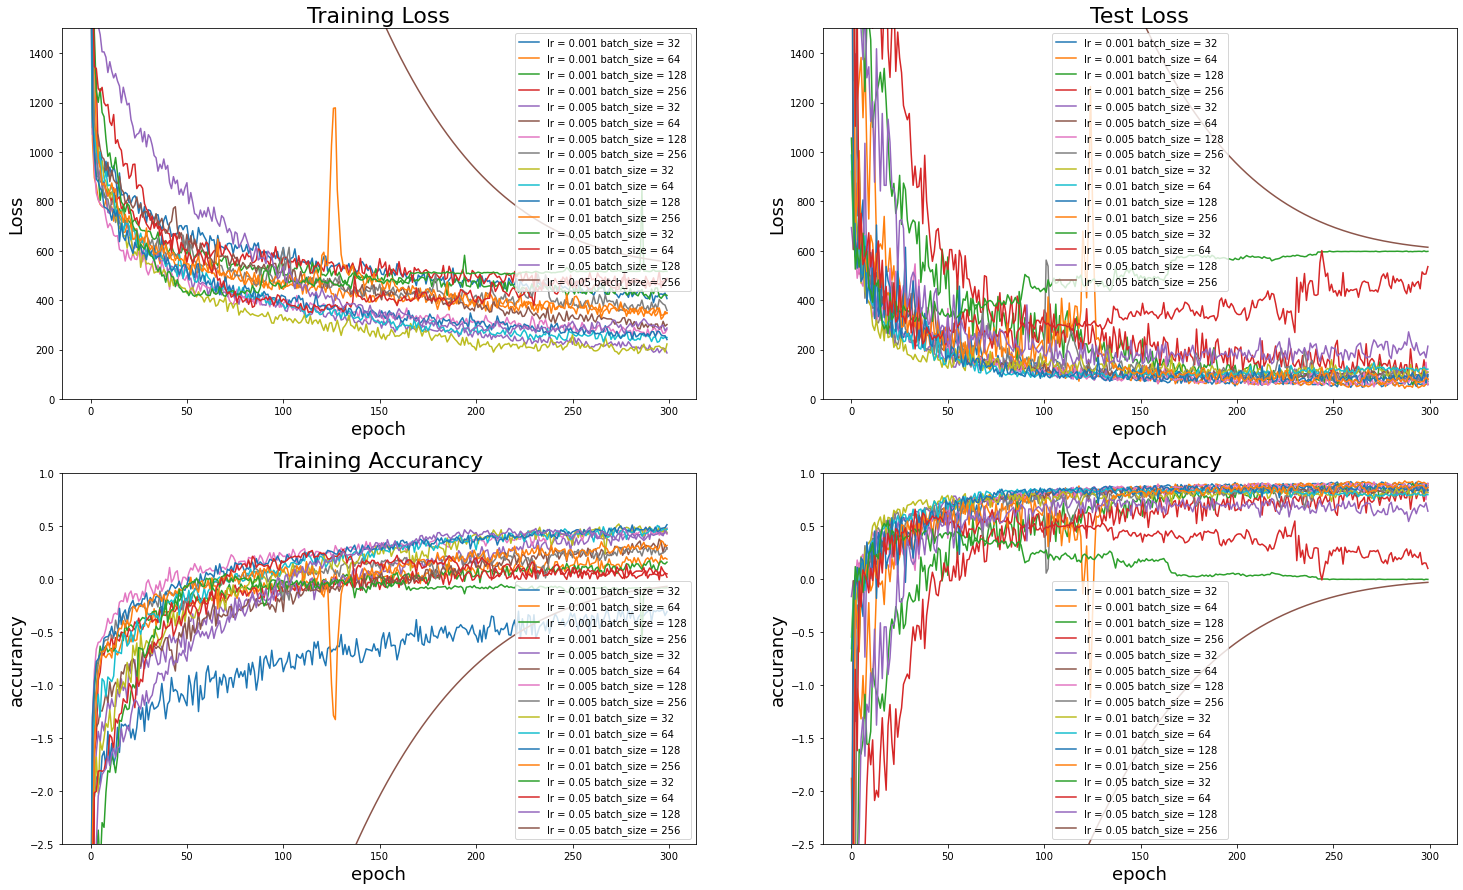

<Figure size 1800x1080 with 0 Axes>

In [13]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.001 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.001 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.001 batch_size = 128")
    ax.plot(data_list[3],label="lr = 0.001 batch_size = 256")

    ax.plot(data_list[4],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[5],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[6],label="lr = 0.005 batch_size = 128")
    ax.plot(data_list[7],label="lr = 0.005 batch_size = 256")

    ax.plot(data_list[8],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[9],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[10],label="lr = 0.01 batch_size = 128")
    ax.plot(data_list[11],label="lr = 0.01 batch_size = 256")

    ax.plot(data_list[12],label="lr = 0.05 batch_size = 32")
    ax.plot(data_list[13],label="lr = 0.05 batch_size = 64")
    ax.plot(data_list[14],label="lr = 0.05 batch_size = 128")
    ax.plot(data_list[15],label="lr = 0.05 batch_size = 256")

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Training Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("Loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 1500])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("Loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 1500])

ax3.set_title("Training Accurancy", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("accurancy", fontsize=18)
ax3.legend()
ax3.set_ylim([-2.5,1])

ax4.set_title("Test Accurancy", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("accurancy", fontsize=18)
ax4.legend()
ax4.set_ylim([-2.5,1])

plt.show()

In [14]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   
    

-0.3080951997104356
0.18829070550700092
0.1599093221830452
0.04947248072548635
0.48024408695642845
0.2841504327570463
0.4246128563056049
0.2959774232371474
0.43816736890455005
0.4696390509070724
0.5130259532472422
0.31725317846735224
-0.08181057996088535
0.017906717402606805
0.43418544424626415
-0.06910571037967952
___________________

0.9008856659625841
0.8983488524612325
0.8817100618942034
0.8645339759391921
0.8174228005006839
0.8363551013524329
0.9035338631469041
0.8474817424417593
0.8162868720170048
0.7970921393831618
0.8354729501454204
0.8660535842801297
-0.0032014156185928844
0.10050230375117986
0.640966368592325
-0.031150688274156124
___________________

406.542645127026
349.7604190602022
419.3031957289752
488.55417887369794
186.58446878461694
301.61211170869717
281.3623935475069
358.8132019042969
222.88215443625378
249.00732556511375
240.69478921329275
346.3578745524089
516.6546844937908
484.3859230490292
287.37751321231616
555.0395067003038
___________________

59.048679351806

### 2 best models

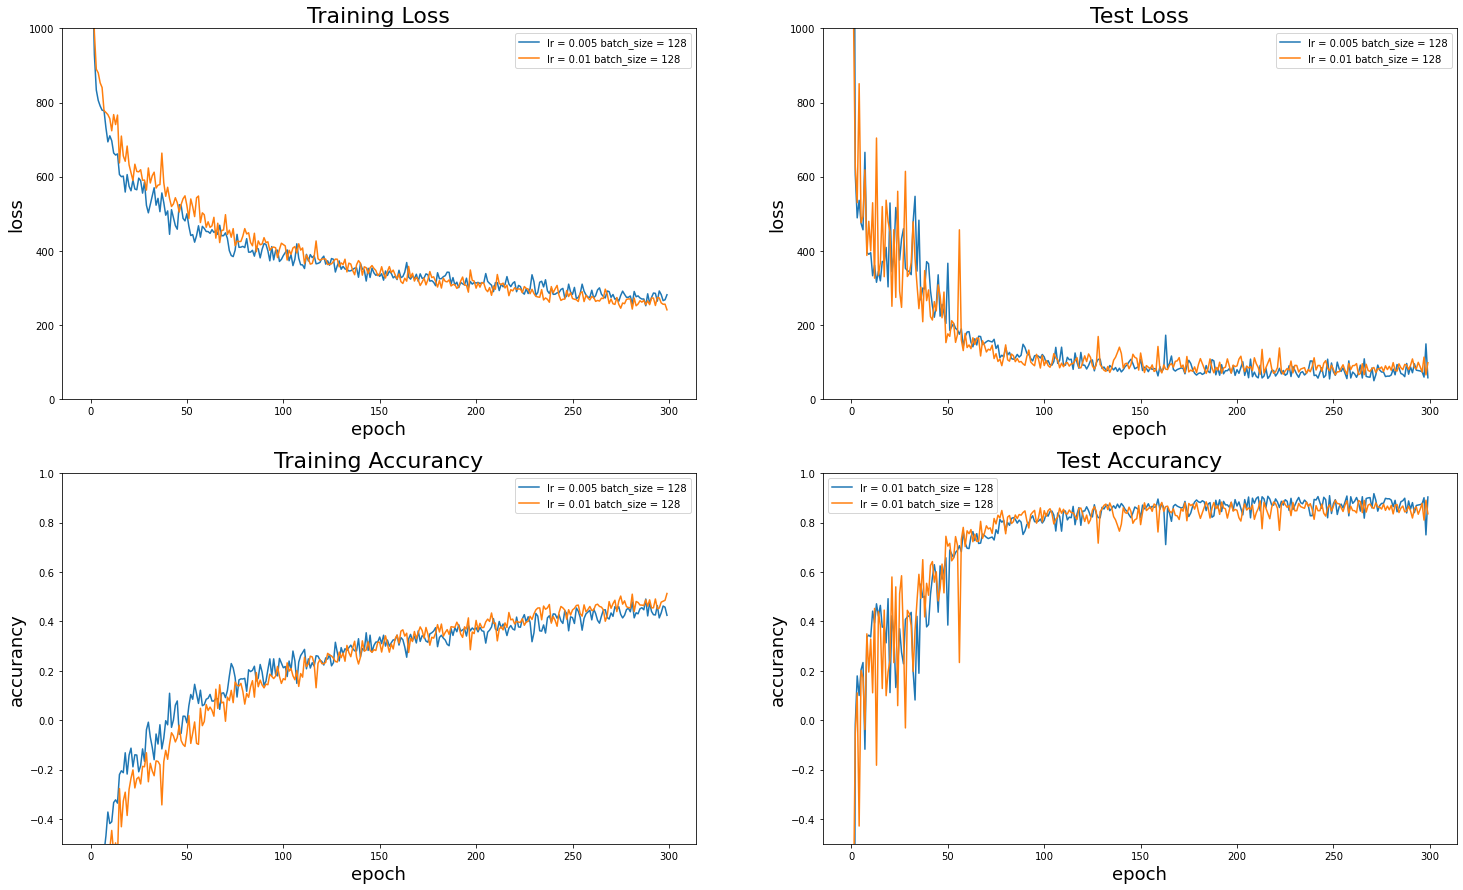

<Figure size 432x288 with 0 Axes>

In [18]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Training Loss", fontsize=22)
ax1.plot(train_losses_all[6],label="lr = 0.005 batch_size = 128")
ax1.plot(train_losses_all[10],label="lr = 0.01 batch_size = 128")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 1000])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[6],label="lr = 0.005 batch_size = 128")
ax2.plot(test_losses_all[10],label="lr = 0.01 batch_size = 128")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 1000])

ax3.set_title("Training Accurancy", fontsize=22)
ax3.plot(train_accs_all[6],label="lr = 0.005 batch_size = 128")
ax3.plot(train_accs_all[10],label="lr = 0.01 batch_size = 128")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("accurancy", fontsize=18)
ax3.legend()
ax3.set_ylim([-0.5,1])

ax4.set_title("Test Accurancy", fontsize=22)
ax4.plot(test_accs_all[6],label="lr = 0.01 batch_size = 128")
ax4.plot(test_accs_all[10],label="lr = 0.01 batch_size = 128")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("accurancy", fontsize=18)
ax4.legend()
ax4.set_ylim([-0.5,1])
plt.show()

## 4.2. Training

In [19]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_all.values), torch.FloatTensor(y_train_all.values.reshape(-1, 1)))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test.values.reshape(-1, 1)))
test_loader = DataLoader(test_dataset, batch_size=533, shuffle=False)

In [20]:
model = FCNN()
model.cuda()

epochs = 300
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.01)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_value = 1000
best_params = {'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    
    print('################## EPOCH {} ##################'.format(epoch))
    
    model.train()
    train_correct = 0
    train_loss = 0

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct/len(train_loader)
    train_accs.append(train_acc)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("R2/train", train_acc, epoch)
    print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    
    model.eval()
    
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
        
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc =test_correct/len(test_loader)
    test_accs.append(test_acc)

    if test_loss<best_value:
        best_value = test_loss
        torch.save(model.state_dict(), '../../models/protein_maccs_fcnn_model.pt')
        best_params['epoch'] = epoch
        best_params['train_loss'] = train_loss
        best_params['test_loss'] = test_loss
        best_params['train_acc'] = train_acc
        best_params['test_acc'] = test_acc 
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("R2/test", test_acc, epoch)

    print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

writer.flush()
writer.close()

print(best_params)

################## EPOCH 1 ##################
Train Avg. loss: 2340.8068057789524, Accuracy: -3.733980995834419
Test Avg. loss: 2081.830322265625, Accuracy: -3.5111836343472955
################## EPOCH 2 ##################
Train Avg. loss: 1200.572057387408, Accuracy: -1.39978938527038
Test Avg. loss: 658.7390747070312, Accuracy: -0.4274425061627778
################## EPOCH 3 ##################
Train Avg. loss: 963.530122644761, Accuracy: -0.9373366654606874
Test Avg. loss: 696.6237182617188, Accuracy: -0.5095358800595404
################## EPOCH 4 ##################
Train Avg. loss: 877.4128741096048, Accuracy: -0.7580140527260714
Test Avg. loss: 598.312255859375, Accuracy: -0.29650153945196567
################## EPOCH 5 ##################
Train Avg. loss: 888.724214441636, Accuracy: -0.7552689119635664
Test Avg. loss: 503.1240539550781, Accuracy: -0.09023540502086047
################## EPOCH 6 ##################
Train Avg. loss: 834.9838292738971, Accuracy: -0.653182466160174
Test Av

Train Avg. loss: 513.713228113511, Accuracy: -0.041054429072557255
Test Avg. loss: 290.87353515625, Accuracy: 0.36969701070608885
################## EPOCH 49 ##################
Train Avg. loss: 506.4579862706801, Accuracy: -0.02586539124431851
Test Avg. loss: 251.79649353027344, Accuracy: 0.4543742335961034
################## EPOCH 50 ##################
Train Avg. loss: 563.0582867790671, Accuracy: -0.14175833735069587
Test Avg. loss: 287.9516906738281, Accuracy: 0.37602844250890366
################## EPOCH 51 ##################
Train Avg. loss: 512.418056712431, Accuracy: -0.03705353920855855
Test Avg. loss: 281.2430419921875, Accuracy: 0.3905655700744717
################## EPOCH 52 ##################
Train Avg. loss: 509.31156472598803, Accuracy: -0.025912606749721956
Test Avg. loss: 250.7638702392578, Accuracy: 0.4566118857642967
################## EPOCH 53 ##################
Train Avg. loss: 495.6074649586397, Accuracy: 0.009324556657524819
Test Avg. loss: 292.79132080078125, Accur

Train Avg. loss: 407.1581008013557, Accuracy: 0.1684482165624741
Test Avg. loss: 235.10826110839844, Accuracy: 0.49053651062326653
################## EPOCH 97 ##################
Train Avg. loss: 414.8479434742647, Accuracy: 0.16827407650869589
Test Avg. loss: 217.0851593017578, Accuracy: 0.5295913496971013
################## EPOCH 98 ##################
Train Avg. loss: 394.9949753705193, Accuracy: 0.20153087658186686
Test Avg. loss: 213.27691650390625, Accuracy: 0.5378435843728582
################## EPOCH 99 ##################
Train Avg. loss: 393.1641414866728, Accuracy: 0.19662356474913692
Test Avg. loss: 218.5059814453125, Accuracy: 0.5265125237100223
################## EPOCH 100 ##################
Train Avg. loss: 407.20980116900273, Accuracy: 0.18321762054023444
Test Avg. loss: 220.65065002441406, Accuracy: 0.5218651974761244
################## EPOCH 101 ##################
Train Avg. loss: 384.11683654785156, Accuracy: 0.22694234536627528
Test Avg. loss: 208.43609619140625, Accura

Train Avg. loss: 367.71802475873164, Accuracy: 0.25732335161841163
Test Avg. loss: 221.3099822998047, Accuracy: 0.5204364373919419
################## EPOCH 143 ##################
Train Avg. loss: 351.67297542796416, Accuracy: 0.29627362330807167
Test Avg. loss: 222.51449584960938, Accuracy: 0.5178263409561918
################## EPOCH 144 ##################
Train Avg. loss: 345.53165749942553, Accuracy: 0.30225954007926636
Test Avg. loss: 202.7207489013672, Accuracy: 0.5607180462845918
################## EPOCH 145 ##################
Train Avg. loss: 353.754368501551, Accuracy: 0.2863024666175479
Test Avg. loss: 197.310302734375, Accuracy: 0.5724421272873147
################## EPOCH 146 ##################
Train Avg. loss: 318.76245565975415, Accuracy: 0.3539056101681229
Test Avg. loss: 220.7476806640625, Accuracy: 0.5216548854539069
################## EPOCH 147 ##################
Train Avg. loss: 345.87143123851104, Accuracy: 0.2989102658417249
Test Avg. loss: 223.8324432373047, Accuracy

Train Avg. loss: 331.01843082203584, Accuracy: 0.3254657656404854
Test Avg. loss: 214.52297973632812, Accuracy: 0.5351433901136058
################## EPOCH 189 ##################
Train Avg. loss: 311.78361690745635, Accuracy: 0.37422185741319575
Test Avg. loss: 212.0582733154297, Accuracy: 0.5404842410541308
################## EPOCH 190 ##################
Train Avg. loss: 321.1568298339844, Accuracy: 0.3494124944282295
Test Avg. loss: 197.48155212402344, Accuracy: 0.5720710287529394
################## EPOCH 191 ##################
Train Avg. loss: 314.5605244356043, Accuracy: 0.36755674567616414
Test Avg. loss: 220.16500854492188, Accuracy: 0.5229174915669251
################## EPOCH 192 ##################
Train Avg. loss: 311.9458312988281, Accuracy: 0.36544472505952097
Test Avg. loss: 204.43362426757812, Accuracy: 0.5570063256662502
################## EPOCH 193 ##################
Train Avg. loss: 326.5919781853171, Accuracy: 0.34515794289737145
Test Avg. loss: 206.53553771972656, Accu

Train Avg. loss: 297.6465139950023, Accuracy: 0.4071061048490219
Test Avg. loss: 222.06265258789062, Accuracy: 0.5188054794469469
################## EPOCH 236 ##################
Train Avg. loss: 308.79338791791133, Accuracy: 0.37456814414743755
Test Avg. loss: 204.52810668945312, Accuracy: 0.5568016237736586
################## EPOCH 237 ##################
Train Avg. loss: 283.39230885225186, Accuracy: 0.42458214752579915
Test Avg. loss: 228.43508911132812, Accuracy: 0.5049968512808507
################## EPOCH 238 ##################
Train Avg. loss: 293.5046467500574, Accuracy: 0.4105956085581833
Test Avg. loss: 219.2432861328125, Accuracy: 0.5249148306565057
################## EPOCH 239 ##################
Train Avg. loss: 303.00659359202666, Accuracy: 0.38124310277915047
Test Avg. loss: 226.9097442626953, Accuracy: 0.5083021461374189
################## EPOCH 240 ##################
Train Avg. loss: 316.97276395909927, Accuracy: 0.3551302887842762
Test Avg. loss: 221.63185119628906, Accu

Train Avg. loss: 292.48481211942783, Accuracy: 0.4160151123864201
Test Avg. loss: 235.55157470703125, Accuracy: 0.4895758792360231
################## EPOCH 282 ##################
Train Avg. loss: 262.02832928825825, Accuracy: 0.46808164181590856
Test Avg. loss: 217.67800903320312, Accuracy: 0.528306709114605
################## EPOCH 283 ##################
Train Avg. loss: 281.5050210391774, Accuracy: 0.4306535471259759
Test Avg. loss: 221.0784149169922, Accuracy: 0.5209382282954786
################## EPOCH 284 ##################
Train Avg. loss: 267.27717141544116, Accuracy: 0.4680472209599404
Test Avg. loss: 208.6178436279297, Accuracy: 0.5479394490061773
################## EPOCH 285 ##################
Train Avg. loss: 269.5341366038603, Accuracy: 0.45611252563358073
Test Avg. loss: 217.2360382080078, Accuracy: 0.5292644013768837
################## EPOCH 286 ##################
Train Avg. loss: 287.08988144818477, Accuracy: 0.41592704173821277
Test Avg. loss: 206.68728637695312, Accura

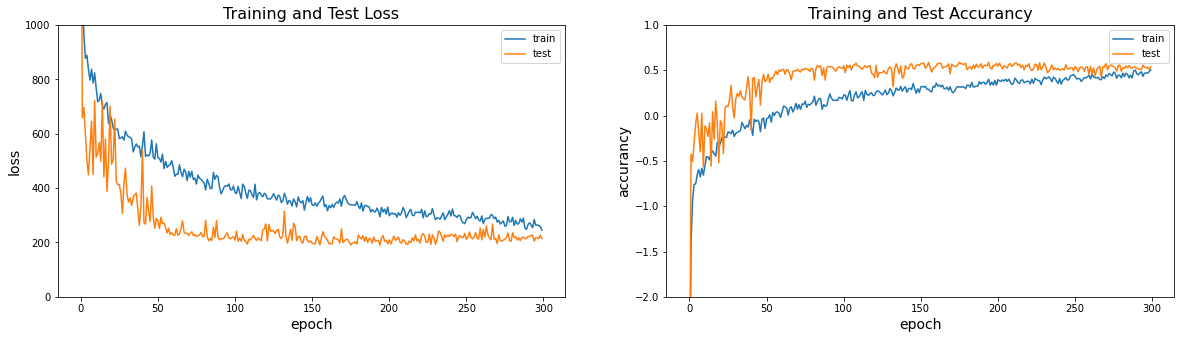

<Figure size 1440x360 with 0 Axes>

In [24]:
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Training and Test Loss", fontsize=16)
ax1.plot(train_losses,label="train")
ax1.plot(test_losses,label="test")
ax1.set_xlabel("epoch", fontsize=14)
ax1.set_ylabel("loss", fontsize=14)
ax1.set_ylim([0,1000])
ax1.legend()

ax2.set_title("Training and Test Accurancy", fontsize=16)
ax2.plot(train_accs,label="train")
ax2.plot(test_accs,label="test")
ax2.set_xlabel("epoch", fontsize=14)
ax2.set_ylabel("accurancy", fontsize=14)
ax2.set_ylim([-2,1])
ax2.legend()
plt.show()

In [22]:
model = FCNN()
model.load_state_dict(torch.load('../../models/protein_maccs_fcnn_model.pt'))
model.cuda()
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        predictons = output.cpu().detach().numpy()
        print_evaluate(target.cpu().detach().numpy(), predictons)

MAE: 8.530869
MSE: 190.18846
RMSE: 13.790883
R2 Square 0.5878746107109848 

